## Анализ и прогнозирование временных рядов

Данные: https://www.kaggle.com/datasets/arashnic/time-series-forecasting-with-yahoo-stock-price

In [185]:
import datetime     # Работа с датами
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams    # Дополнительный модуль для построения графиков
from sklearn.metrics import mean_absolute_error
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Первичный анализ данных (EDA)

In [186]:
df = pd.read_csv('Data/yahoo_stock.csv')
df.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117


Установим Date как индекс

In [187]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()

In [9]:
df.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [10]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1825.000000
mean,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09,2647.856284
std,409.680853,404.310068,407.169994,407.301177,1.087593e+09,407.301177
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09,2328.949951
50%,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09,2683.340088
75%,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09,2917.520020
max,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912


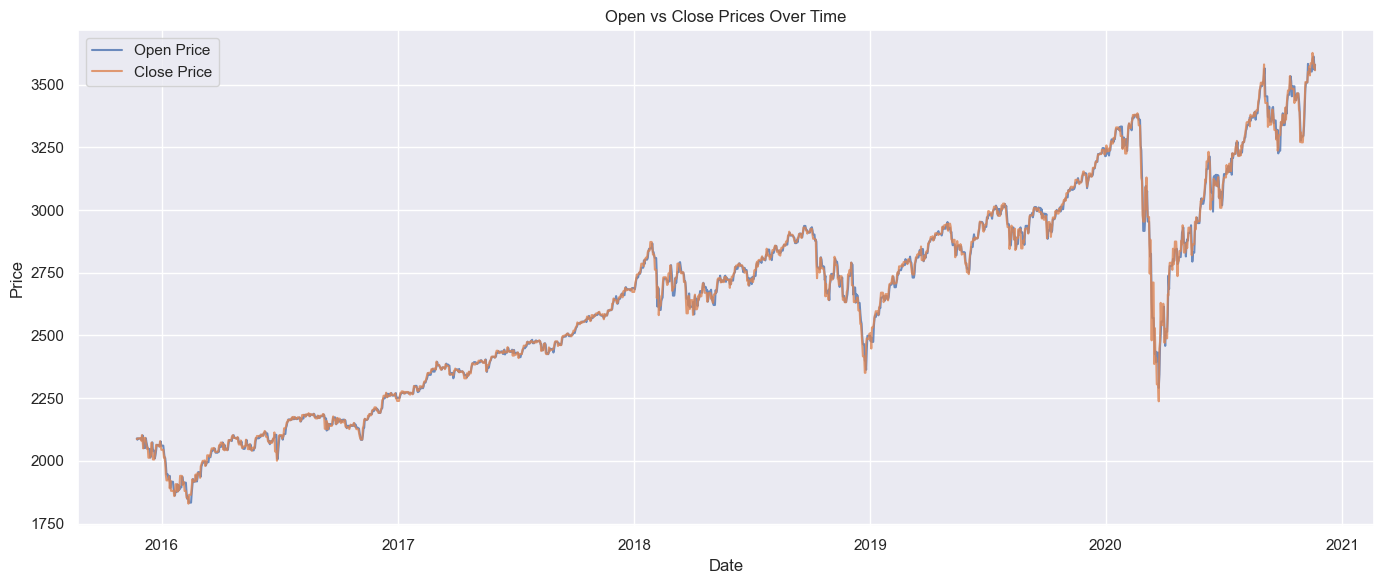

In [ ]:

plt.figure(figsize=(14, 6))
plt.plot(df['Open'], label='Open Price', alpha=0.8)
plt.plot(df['Close'], label='Close Price', alpha=0.8)
plt.title("Open vs Close Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

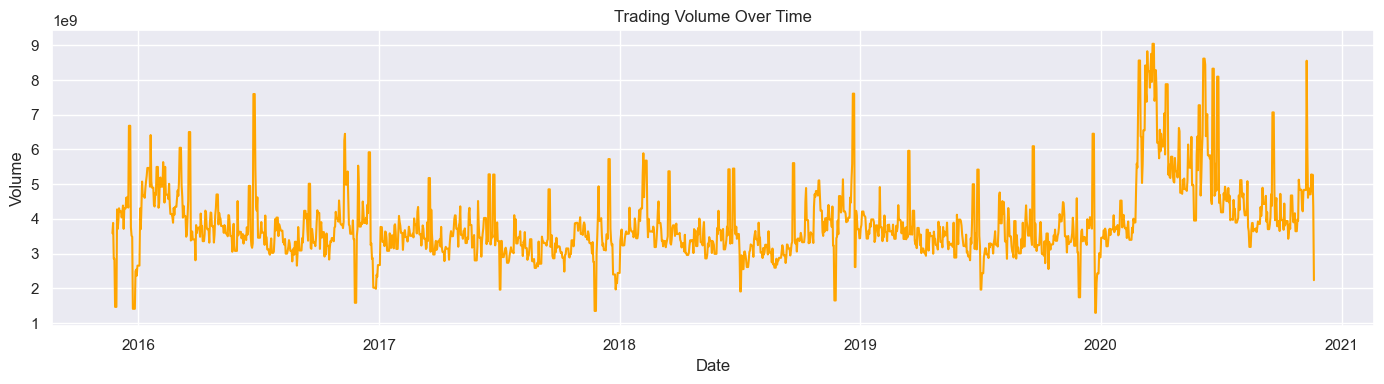

In [13]:
plt.figure(figsize=(14, 4))
plt.plot(df['Volume'], label='Volume', color='orange')
plt.title("Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

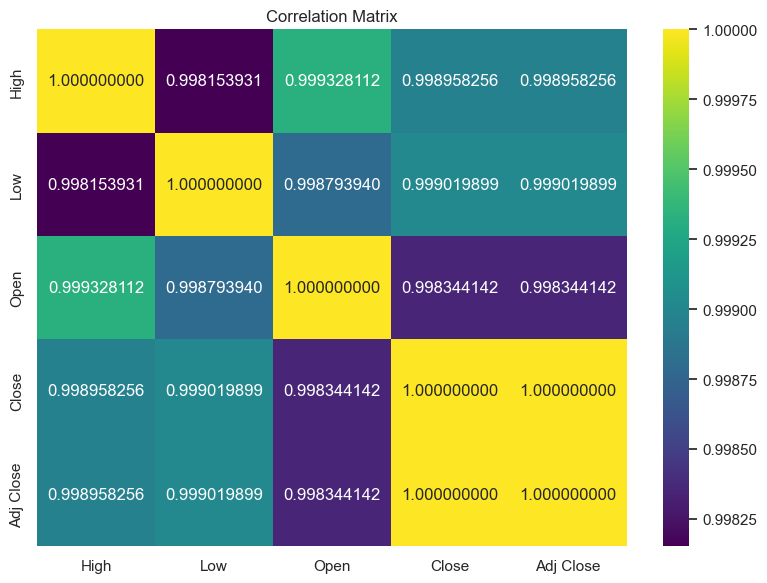

In [14]:
df_corr = df.drop('Volume', axis=1)
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr.corr(numeric_only=True), annot=True, cmap='viridis', fmt=".9f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

Можем наблюдать высокую прямую корреляцию со всеми признаками, что естественно для временного ряда

In [98]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

Посмотрим, как выглядит временной ряд по признаку "цена закрытия"

<Axes: title={'center': 'Цена закрытия'}, xlabel='Date'>

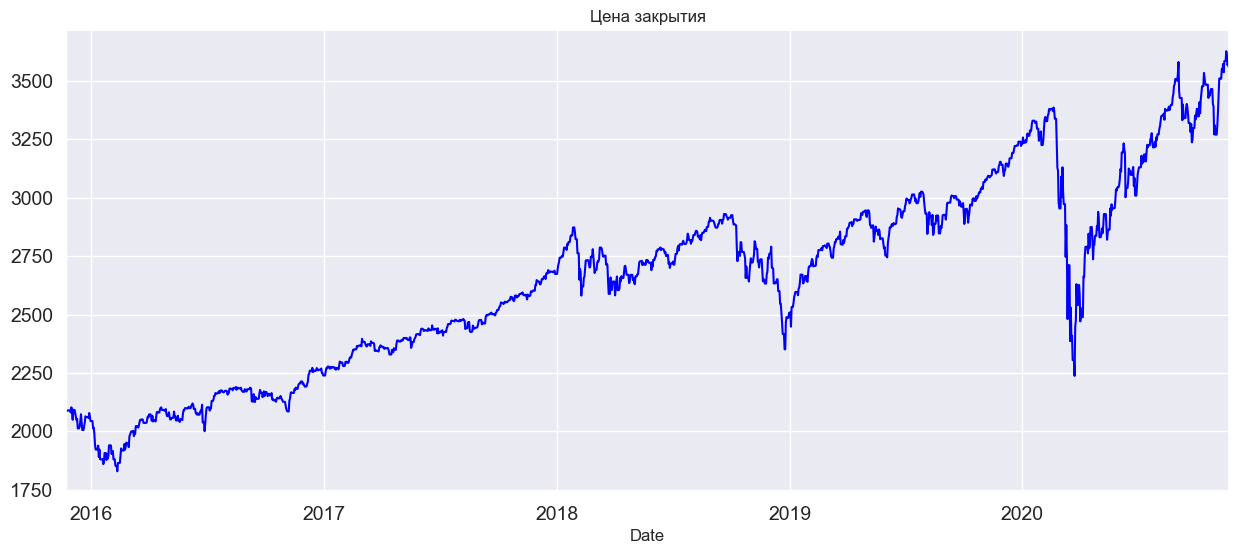

In [15]:
df.Close.plot( figsize=(15,6),title= 'Цена закрытия', fontsize=14, color="blue")

### Feature engeneering

In [125]:
import ta  

# Lag-фичи 
for lag in [1, 2, 3, 5, 7, 10]:
    df[f'lag_{lag}'] = df['Close'].shift(lag)

# Rolling-статистики 
for window in [5, 10, 20]:
    df[f'roll_mean_{window}'] = df['Close'].rolling(window).mean()
    df[f'roll_median_{window}'] = df['Close'].rolling(window).median()
    df[f'roll_std_{window}'] = df['Close'].rolling(window).std()

# Доходность 
df['return_pct'] = df['Close'].pct_change()
df['return_log'] = np.log(df['Close'] / df['Close'].shift(1))

# Трендовые индикаторы (ta library) 
# EMA (Exponential Moving Average)
df['ema_10'] = ta.trend.EMAIndicator(close=df['Close'], window=10).ema_indicator()
df['ema_50'] = ta.trend.EMAIndicator(close=df['Close'], window=50).ema_indicator()

# RSI
df['rsi_14'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()

# MACD
from ta.trend import MACD
macd = MACD(close=df['Close']) 
df['macd'] = macd.macd()               
df['macd_signal'] = macd.macd_signal()  
df['macd_diff'] = macd.macd_diff()      

# Bollinger Bands
boll = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
df['bollinger_mavg'] = boll.bollinger_mavg()
df['bollinger_high'] = boll.bollinger_hband()
df['bollinger_low'] = boll.bollinger_lband()

df['day_of_week'] = df.index.dayofweek     # 0=Пн, 6=Вс
df['month'] = df.index.month
df['is_month_start'] = df.index.is_month_start.astype(int)
df['is_month_end'] = df.index.is_month_end.astype(int)

df = df.dropna()

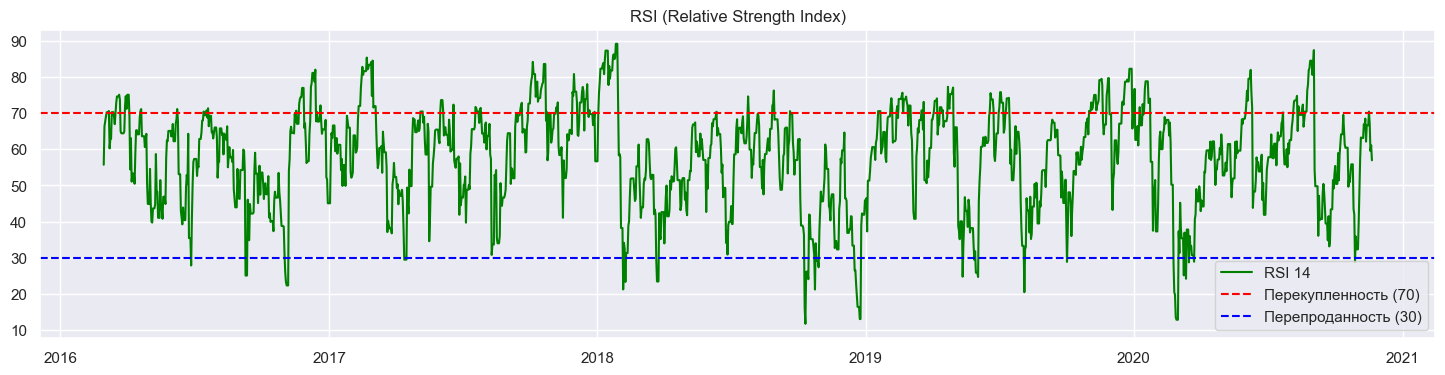

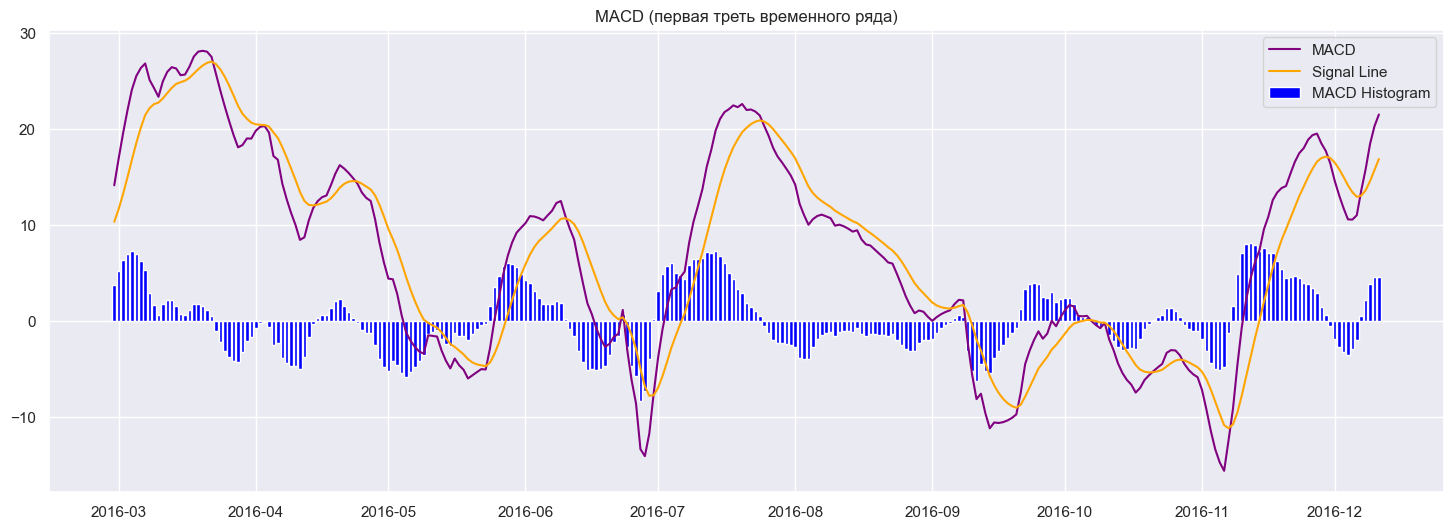

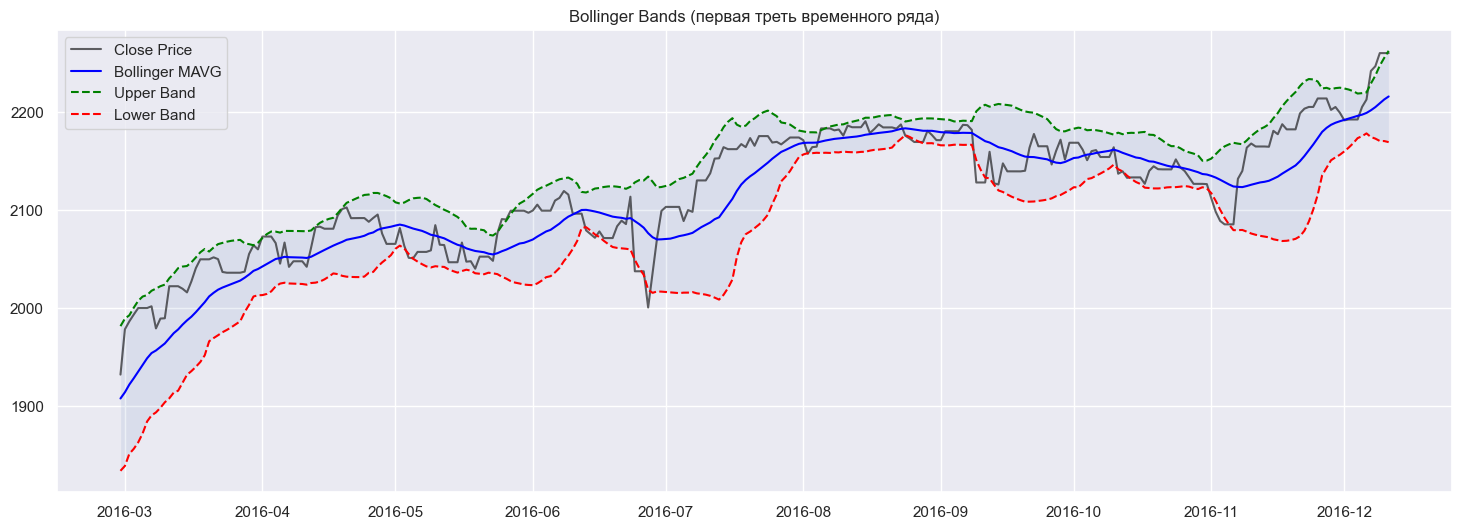

In [123]:
df = df.copy()
if not isinstance(df.index, pd.DatetimeIndex):
    df = df.set_index('Date')

plt.figure(figsize=(18, 4))
plt.plot(df['rsi_14'], label='RSI 14', color='green')
plt.axhline(70, color='red', linestyle='--', label='Перекупленность (70)')
plt.axhline(30, color='blue', linestyle='--', label='Перепроданность (30)')
plt.title("RSI (Relative Strength Index)")
plt.legend()
plt.grid(True)
plt.show()

n = len(df) // 6
df_first = df.iloc[:n] 

plt.figure(figsize=(18, 6))
plt.plot(df_first['macd'], label='MACD', color='purple')
plt.plot(df_first['macd_signal'], label='Signal Line', color='orange')
plt.bar(df_first.index, df_first['macd_diff'], label='MACD Histogram', color='blue')
plt.title("MACD (первая треть временного ряда)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(df_first['Close'], label='Close Price', color='black', alpha=0.6)
plt.plot(df_first['bollinger_mavg'], label='Bollinger MAVG', color='blue')
plt.plot(df_first['bollinger_high'], label='Upper Band', color='green', linestyle='--')
plt.plot(df_first['bollinger_low'], label='Lower Band', color='red', linestyle='--')
plt.fill_between(df_first.index, df_first['bollinger_low'], df_first['bollinger_high'], alpha=0.1)
plt.title("Bollinger Bands (первая треть временного ряда)")
plt.legend()
plt.grid(True)
plt.show()

Построим графики экспоненциального взвешенного среднего с разными размерами окна

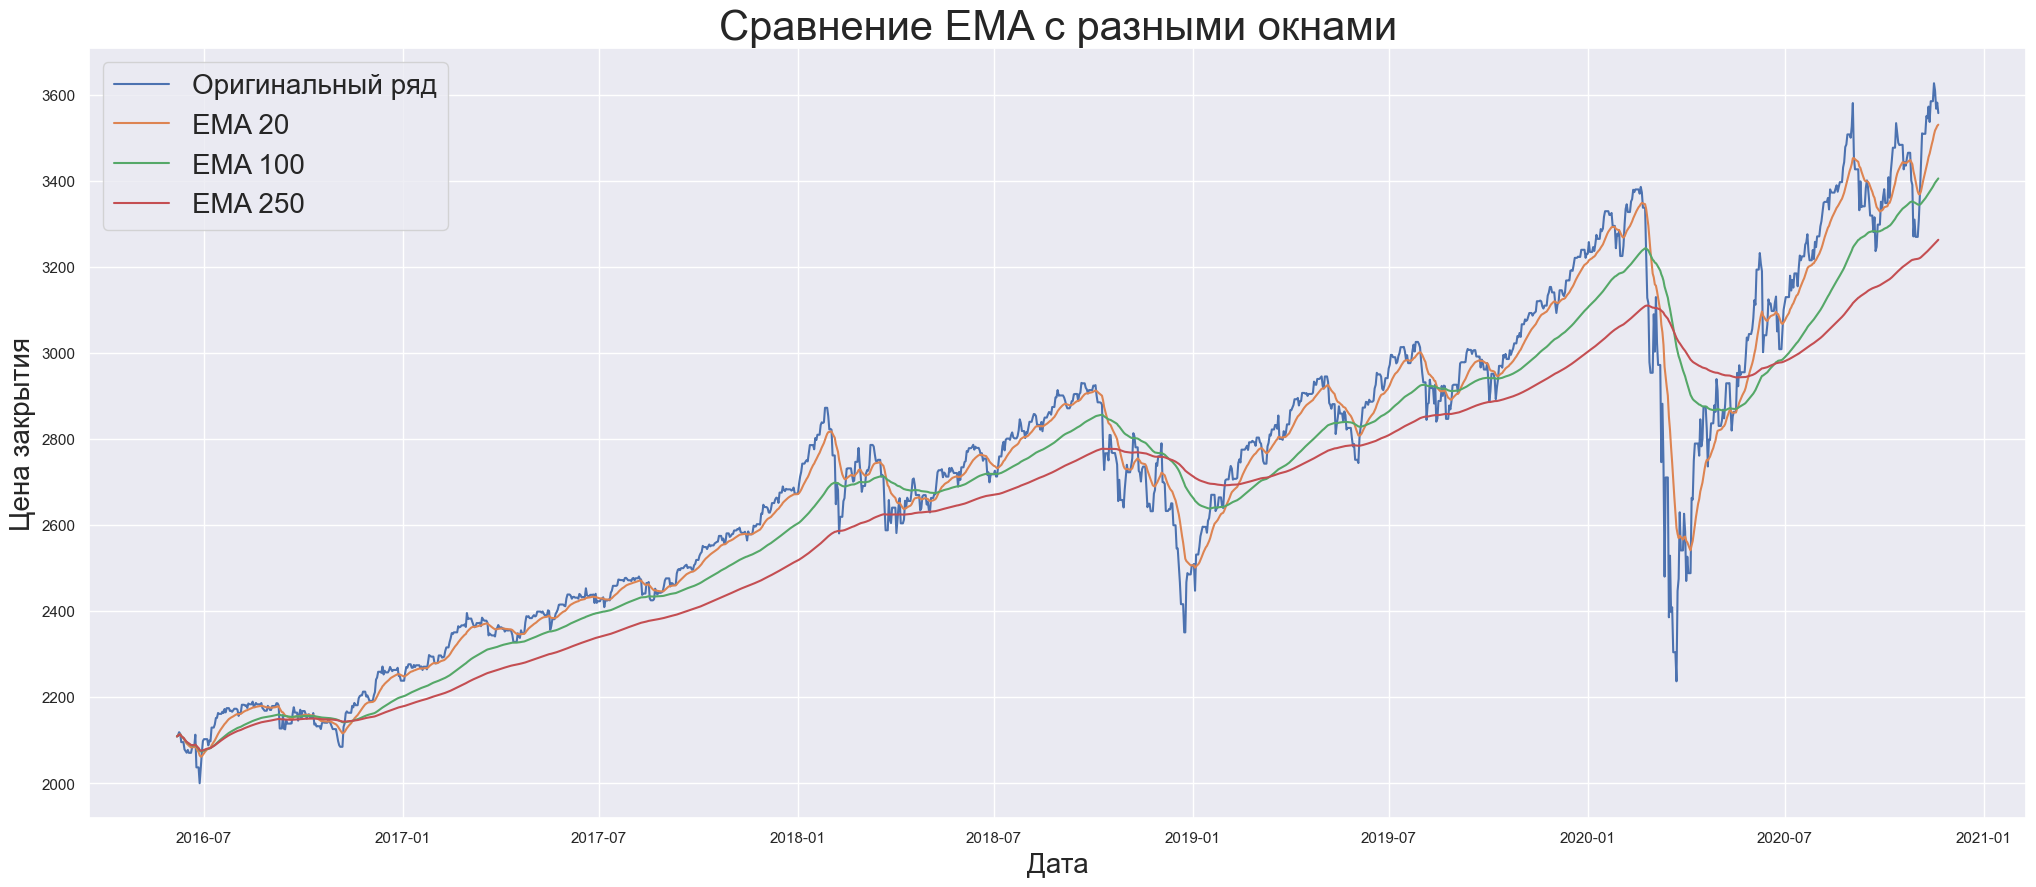

In [128]:
df['ema_20'] = df.Close.ewm(span=20).mean()
df['ema_100'] = df.Close.ewm(span=100).mean()
df['ema_250'] = df.Close.ewm(span=250).mean()

plt.figure(figsize=(25,10))
plt.plot(df.Close, label='Оригинальный ряд')
plt.plot(df.ema_20, label='EMA 20')
plt.plot(df.ema_100, label='EMA 100')
plt.plot(df.ema_250, label='EMA 250')

plt.legend(fontsize=20) 
plt.title('Сравнение EMA с разными окнами', fontsize=30)
plt.xlabel('Дата', fontsize=20)
plt.ylabel('Цена закрытия', fontsize=20)
plt.grid(True)
plt.show()


In [129]:
df['year'] = df.index.year
df['month'] = df.index.month
df['dow'] = df.index.dayofweek
df_pivot = pd.pivot_table(df, values = "Close", columns = "year", index = "month")
df.head(2).round(1)

,High,Low,Open,Close,Volume,Adj Close,lag_1,lag_2,lag_3,lag_5,...,day_of_week,month,is_month_start,is_month_end,macd_diff,ema_20,ema_100,ema_250,year,dow
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-06,2113.4,2100.8,2100.8,2109.4,3.442020e+09,2109.4,2099.1,2099.1,2099.1,2099.3,...,0,6,0,0,2.2,2109.4,2109.4,2109.4,2016,0
2016-06-07,2119.2,2110.2,2110.2,2112.1,3.534730e+09,2112.1,2109.4,2099.1,2099.1,2105.3,...,1,6,0,0,2.2,2110.8,2110.8,2110.8,2016,1


In [46]:
df_pivot.head(2)

year,2016,2017,2018,2019,2020
month,,,,,
1,NaN,2273.866431,2789.382269,2608.389995,3279.136798
2,NaN,2331.553580,2709.020342,2752.977853,3280.883764


Оставим в датасете только те данные, с которыми работаем

In [132]:
lst = ['Close', 'ema_20', 'ema_100', 'ema_250', 'year', 'month', 'dow']
df = df[lst]

Изображение компоненов сезонности на графике

<Axes: title={'center': 'Компонента сезонности'}, xlabel='month'>

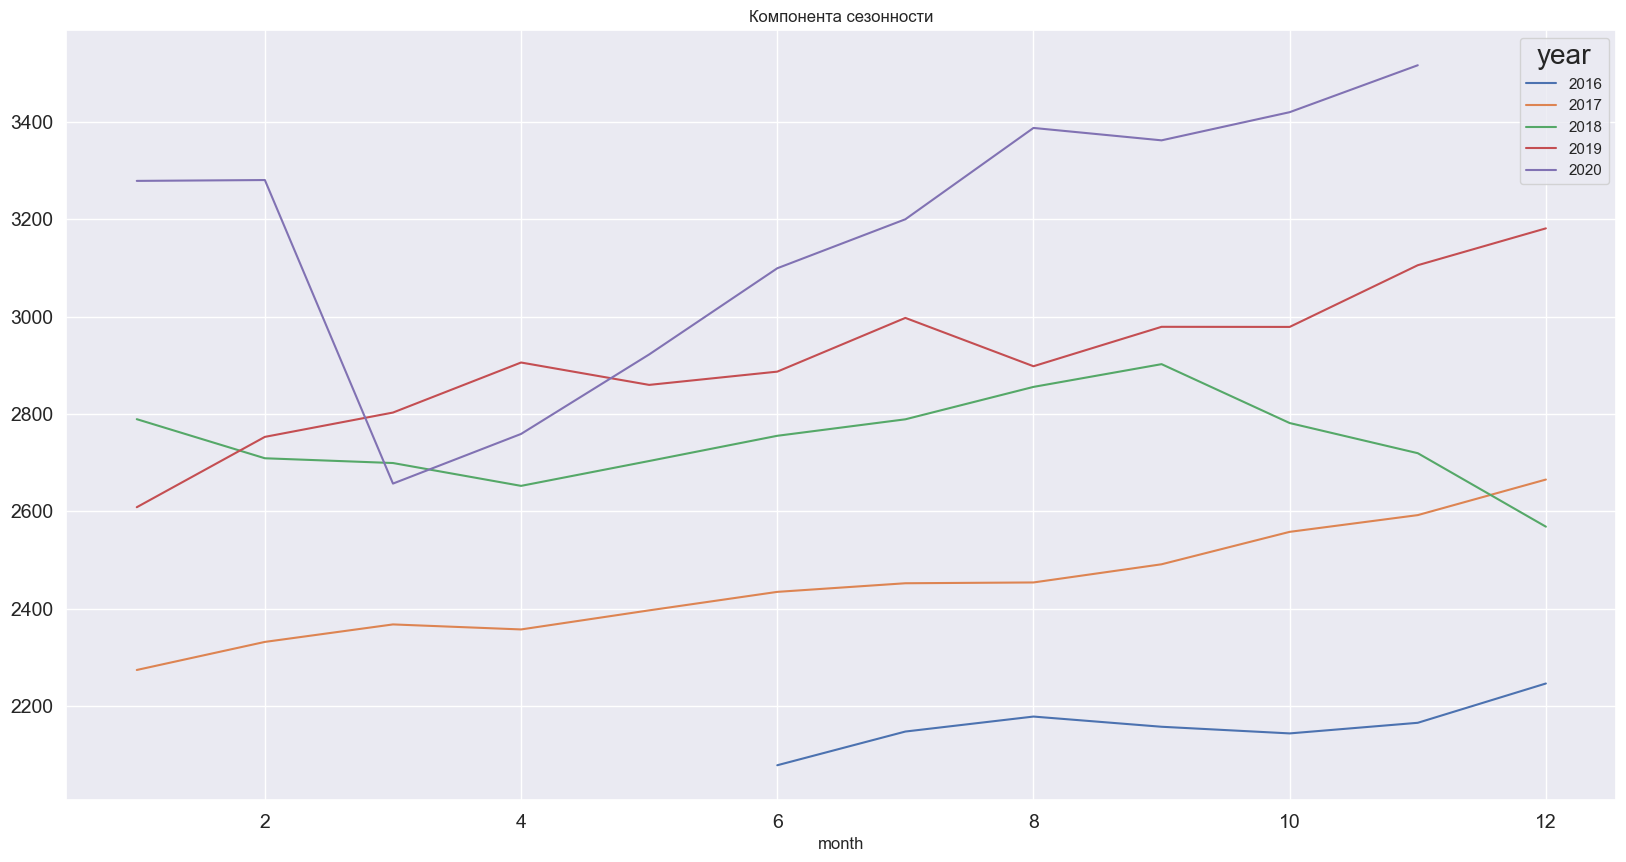

In [133]:
plt.rcParams['legend.title_fontsize'] = 'x-large'

df_pivot.plot( figsize=(20, 10),title= 'Компонента сезонности', fontsize=14)

### Выявим тренд

Тренд можно извлечь с помощью скользящей средней по исходному временному ряду. Также тренд можно извлекать с помощью линейной регрессии.

Каждая точка на первом графике внизу - это среднее за последние 30 дней. Следующая точка аналогично - среднее за следующие 30 дней.

Для того чтобы исполнить эту задумку, мы воспользуемся функцией .rolling, которую вызовем от объекта pd.DataFrame. Эта функция формирует скользящее окно, по которому мы затем можем взять любые статистики. Мы возьмём среднее.

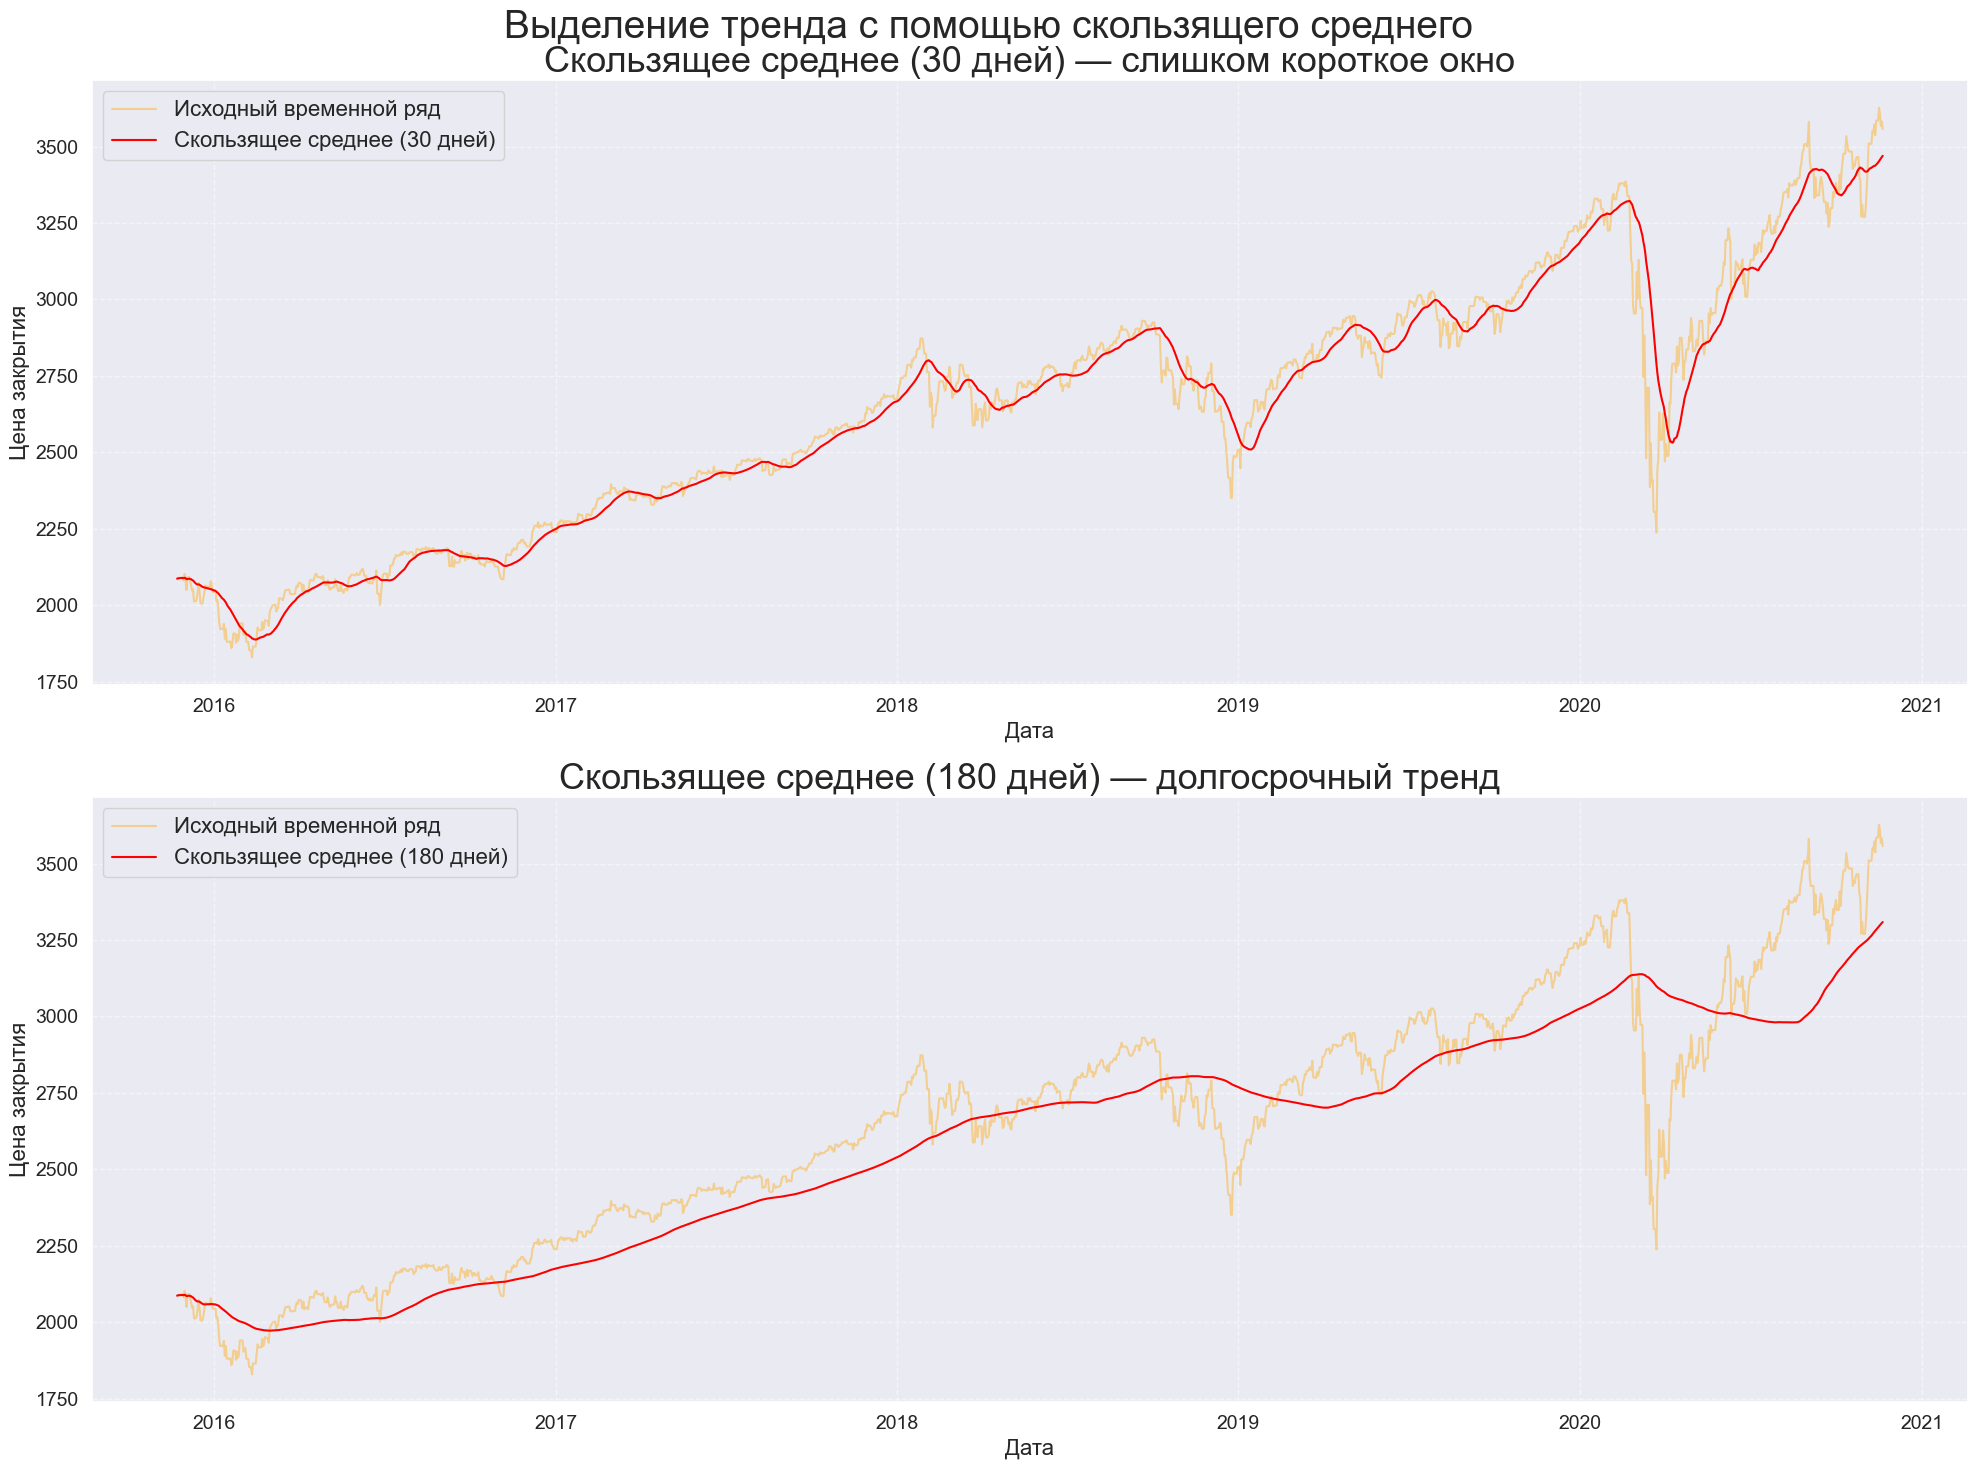

In [48]:
fig, axes = plt.subplots(2, 1, figsize=(20, 15))

window_30d = 30
rolling_mean_30d = df.Close.rolling(window=window_30d, min_periods=1).mean()

axes[0].plot(df.index, df.Close, label='Исходный временной ряд', color="orange", alpha=0.4)
axes[0].plot(df.index, rolling_mean_30d, label='Скользящее среднее (30 дней)', color="red")
axes[0].set_title("Скользящее среднее (30 дней) — слишком короткое окно", fontsize=26)
axes[0].legend(loc='best', fontsize=16)
axes[0].tick_params(axis='both', labelsize=14)
axes[0].set_xlabel("Дата", fontsize=16)
axes[0].set_ylabel("Цена закрытия", fontsize=16)
axes[0].grid(True, linestyle='--', alpha=0.5)

window_180d = 30 * 6
rolling_mean_180d = df.Close.rolling(window=window_180d, min_periods=1).mean()

axes[1].plot(df.index, df.Close, label='Исходный временной ряд', color="orange", alpha=0.4)
axes[1].plot(df.index, rolling_mean_180d, label='Скользящее среднее (180 дней)', color="red")
axes[1].set_title("Скользящее среднее (180 дней) — долгосрочный тренд", fontsize=26)
axes[1].legend(loc='best', fontsize=16)
axes[1].tick_params(axis='both', labelsize=14)
axes[1].set_xlabel("Дата", fontsize=16)
axes[1].set_ylabel("Цена закрытия", fontsize=16)
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle('Выделение тренда с помощью скользящего среднего', fontsize=28)
plt.show()



Для извлечения тренда нужно использовать окно window равное сезонности временного ряда.

Добавим линейную регрессию для выяыления глобального тренда в ряду.

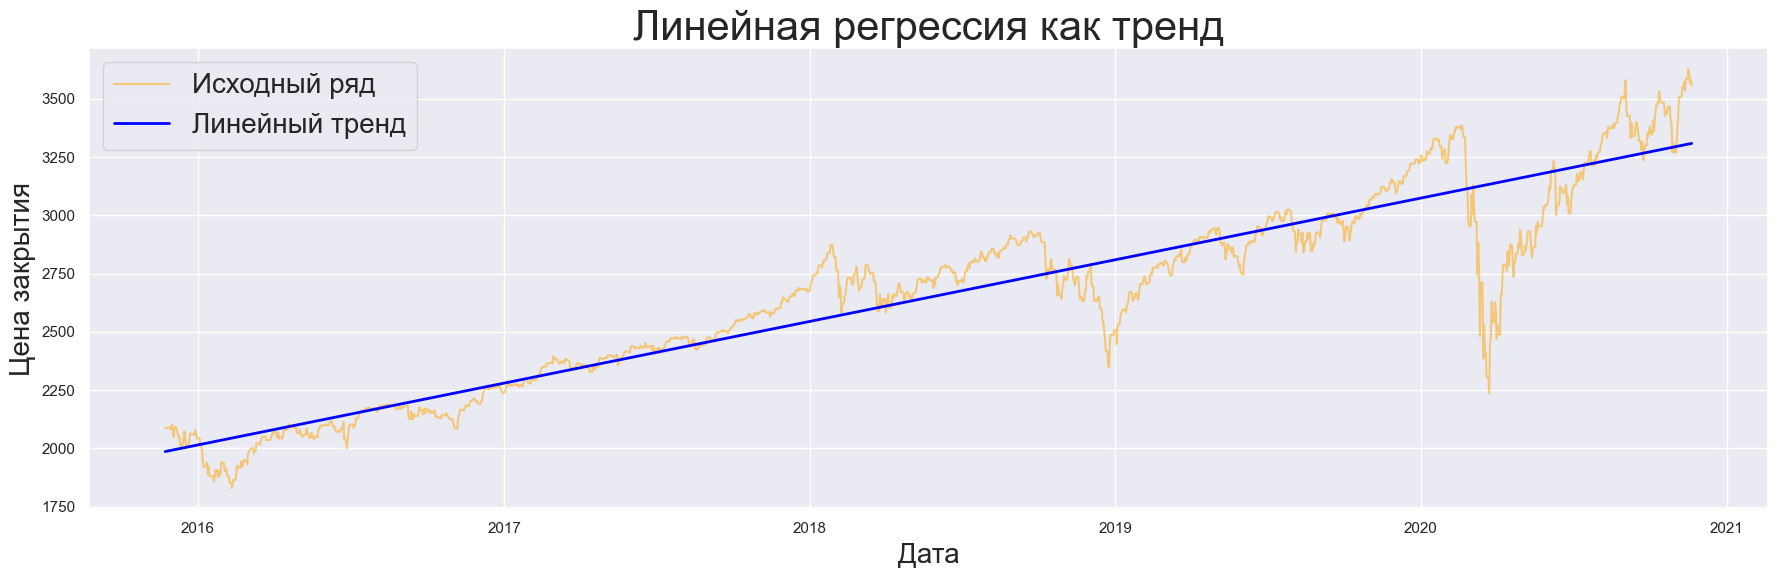

In [51]:
from sklearn.linear_model import LinearRegression

df = df.copy()
df = df.dropna(subset=['Close'])  
df = df.reset_index()

df['time_index'] = np.arange(len(df))

X = df[['time_index']]  
y = df['Close']         

model = LinearRegression()
model.fit(X, y)

df['trend_linear'] = model.predict(X)

plt.figure(figsize=(18, 6))
plt.plot(df['Date'], df['Close'], label='Исходный ряд', color='orange', alpha=0.5)
plt.plot(df['Date'], df['trend_linear'], label='Линейный тренд', color='blue', linewidth=2)
plt.title('Линейная регрессия как тренд', fontsize=30)
plt.xlabel('Дата', fontsize=20)
plt.ylabel('Цена закрытия', fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()


Построим также полиномиальную регрессию:

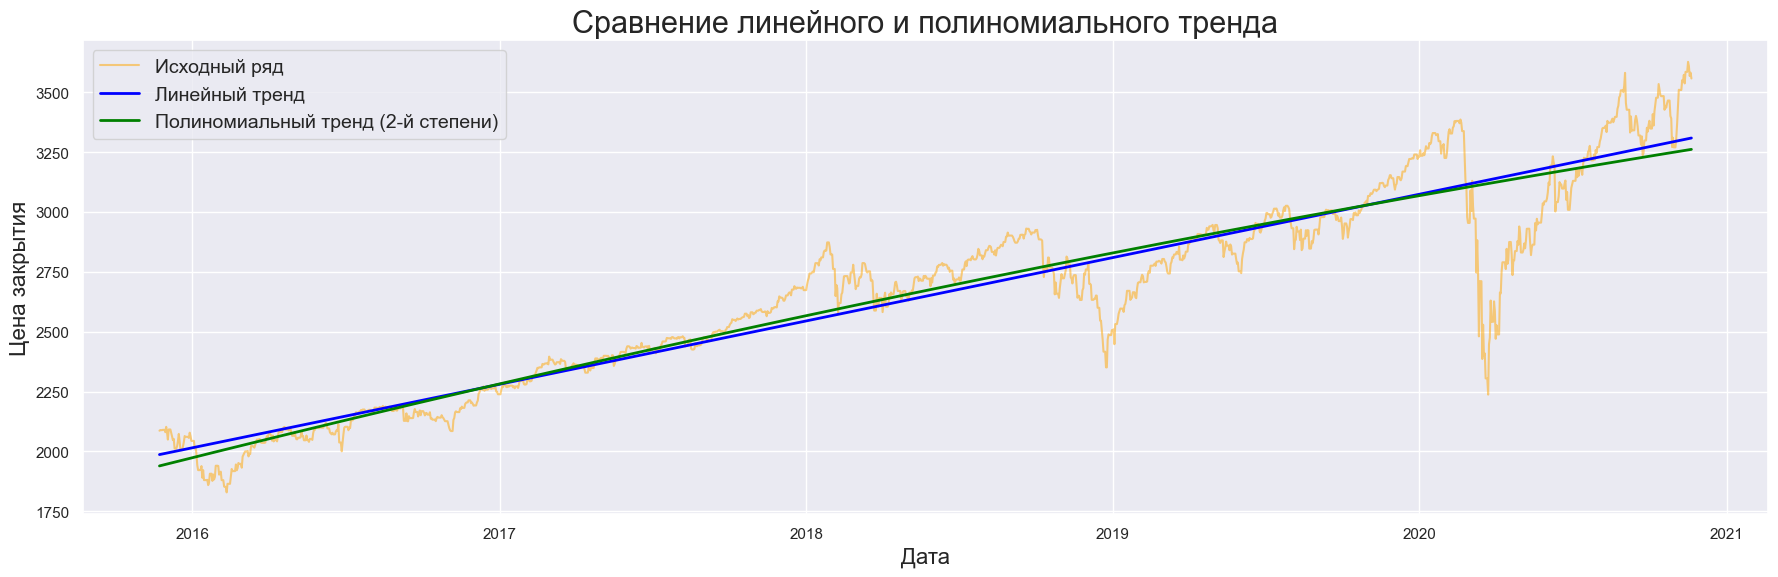

In [54]:
from sklearn.preprocessing import PolynomialFeatures

df = df.copy()
df = df.dropna(subset=['Close'])

df['time_index'] = np.arange(len(df))

X = df[['time_index']]
y = df['Close']

model_linear = LinearRegression()
model_linear.fit(X, y)
df['trend_linear'] = model_linear.predict(X)

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

model_poly = LinearRegression()
model_poly.fit(X_poly, y)
df['trend_poly2'] = model_poly.predict(X_poly)

plt.figure(figsize=(18, 6))
plt.plot(df['Date'], df['Close'], label='Исходный ряд', color='orange', alpha=0.5)
plt.plot(df['Date'], df['trend_linear'], label='Линейный тренд', color='blue', linewidth=2)
plt.plot(df['Date'], df['trend_poly2'], label='Полиномиальный тренд (2-й степени)', color='green', linewidth=2)
plt.title('Сравнение линейного и полиномиального тренда', fontsize=22)
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Цена закрытия', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


Полиномиальная регрессия второго порядка позволяет получить более гибкую аппроксимацию тренда во временном ряду, лучше отражая изгибы и изменения по сравнению с простой линейной моделью.

### Декомпозиция временного ряда

Проведём теперь полноценную декомпозицию временного ряда при помощи статистических методов.

Воспользуемся модулем этой библиотеки, statsmodels.api.

Для работы с временными рядами обратимся к модулю statsmodels.api.tsa (time series analisys), в котором реализована функция seasonal_decompose. В качестве аргументов этой функции мы передаём: df.Close - ряд для декомпозиции, model='additive' - модель декомпозиции и freq= 30 * 6 - частота.

Text(0, 0.5, 'Residual')

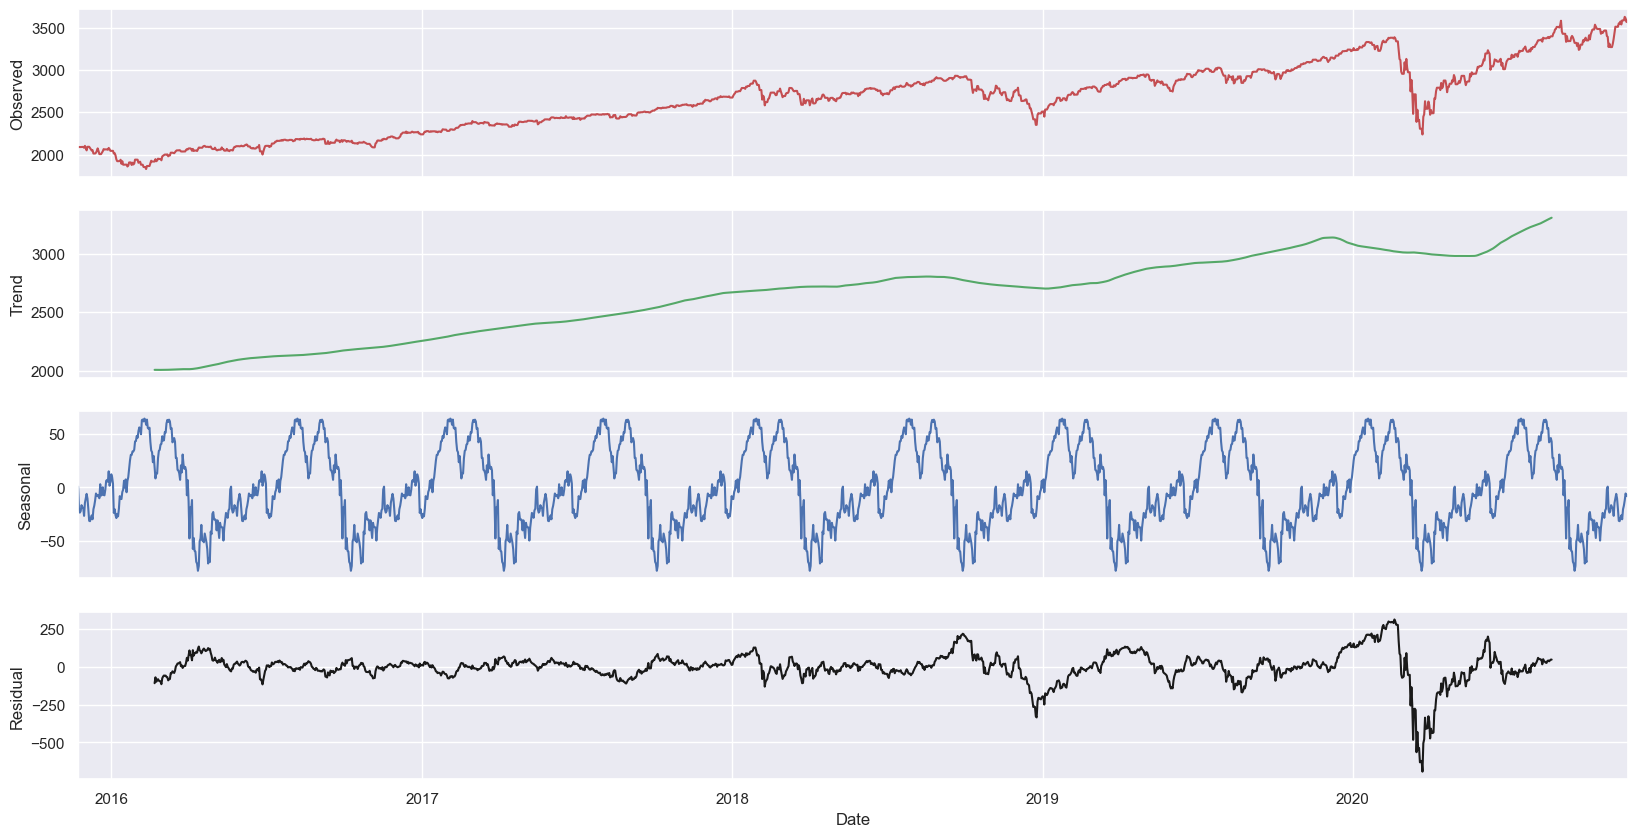

In [33]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.rcParams['font.size'] = 14
plt.rcParams["figure.figsize"] = (20, 10)

res = sm.tsa.seasonal_decompose(df.Close, model='additive', period= 30 * 6)
fig, axes = plt.subplots(4, 1, sharex=True)

res.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')
res.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
res.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
res.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')

Для лучшего понимания проделаем то же собственноручно. Нарисуем исходный временной ряд.

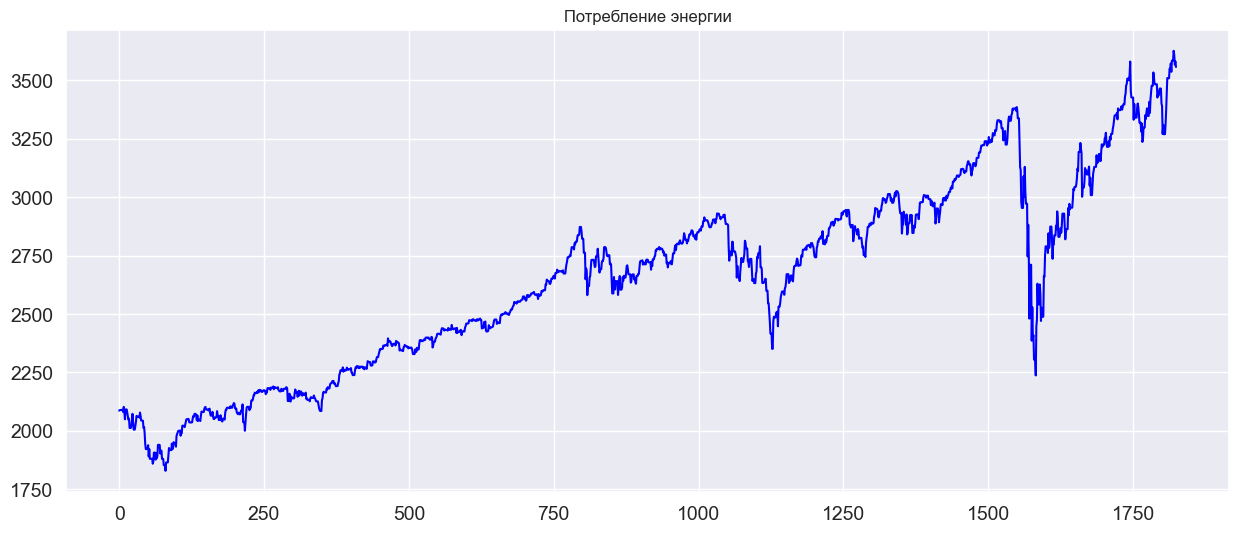

In [59]:
df.Close.plot( figsize=(15,6),title= 'Потребление энергии', fontsize=14, color="blue")
plt.show()

Посчитаем скользящие средние для определения тренда
Вновь воспользуемся функцией .rolling.

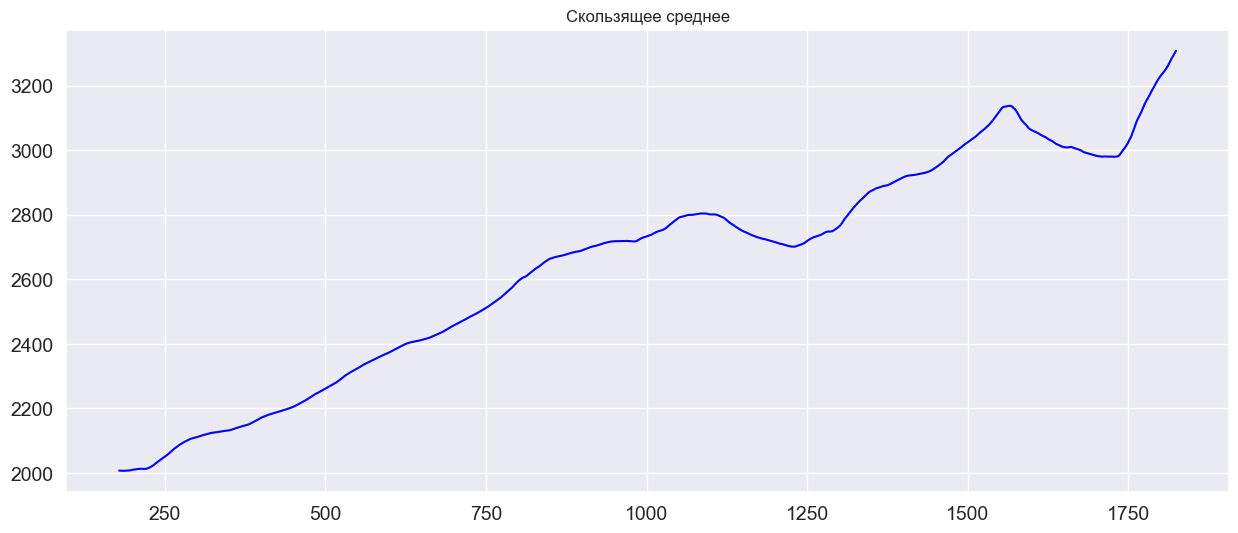

In [60]:
MA = df.Close.rolling(window=30*6).mean()
MA.plot( figsize=(15,6),title= 'Скользящее среднее', fontsize=14, color="blue")
plt.show()

Теперь мы уберём из исходного ряда найденный тренд.

Потихоньку удаляем компоненты ряда, которые мы уже нашли. В зависимости от того, с каким рядом имеем дело, делим или вычитаем его части. MA - убирем тренд, детрендирование.

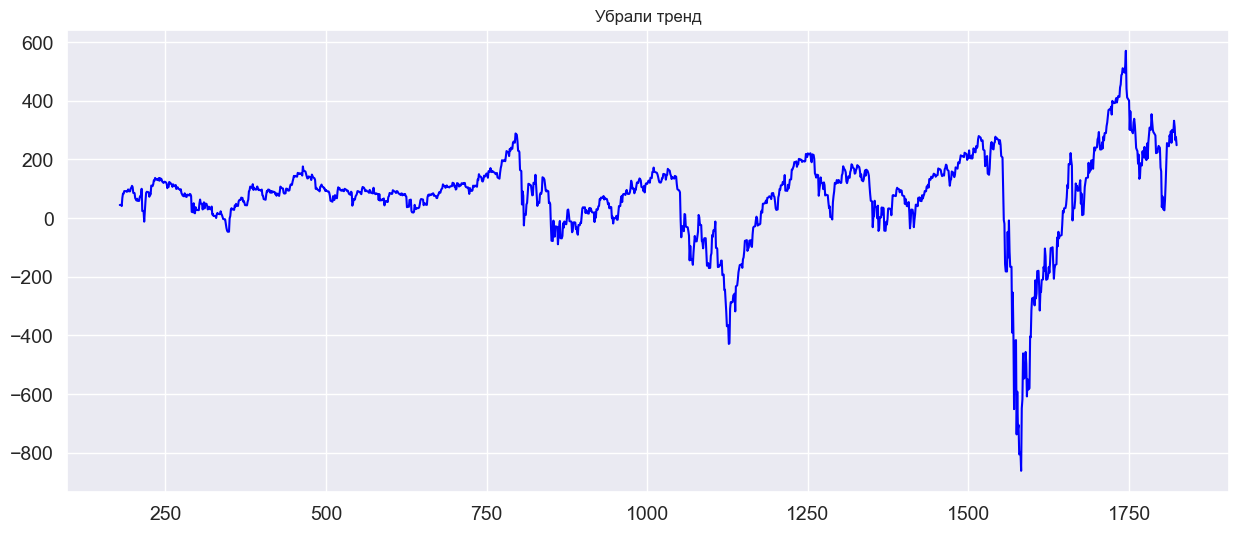

In [61]:
detrend_ = df.Close - MA
detrend_.plot( figsize=(15,6),title= 'Убрали тренд', fontsize=14, color="blue")
plt.show()

Нормализуем по дням сезона. Для простоты реализации воспользуемся функцией pd.core.nanops.pd_nanmean, эта функция позволит нам не думать о пропусках в данных, автоматически корректно их обработать.

In [62]:
from pandas.core.nanops import nanmean as pd_nanmean

def season_mean(x, period):
    """
    Return means for each period in x. period is an int that gives the
    number of periods per cycle. E.g., 12 for monthly. NaNs are ignored
    in the mean.
    """
    return np.array([pd_nanmean(x[i::period], axis=0) for i in range(period)])

В половине года 178 дней. У каждого часа есть свой индекс $i$ - это позиция, которую данный день занимает от начала своего полугодия. На предыдущей картинке была четко заметна сезональность, однако влияние случайных выбросов также довольно велико. Избавимся от них, взяв среднее значение каждого $i$-го дня **по полугодиям**.

То есть, если обозначить за $x_i^j$ $i$-й день $j$-го полугодия, а за $Y$ - количество рассматриваемых полугодий, мы посчитаем такие значения:

$$\bar x_i = \frac{1}{Y}∑\limits_{j=1}^Yx_i^j$$

In [70]:
detrend_ = df['Close'].values - MA.values
season_period = 30 * 6

s_a = season_mean(detrend_, season_period)
s_a = np.asarray(s_a)
s_a -= np.mean(s_a)

nobs = len(detrend_)
seasonal = np.tile(s_a, nobs // season_period + 1)[:nobs]

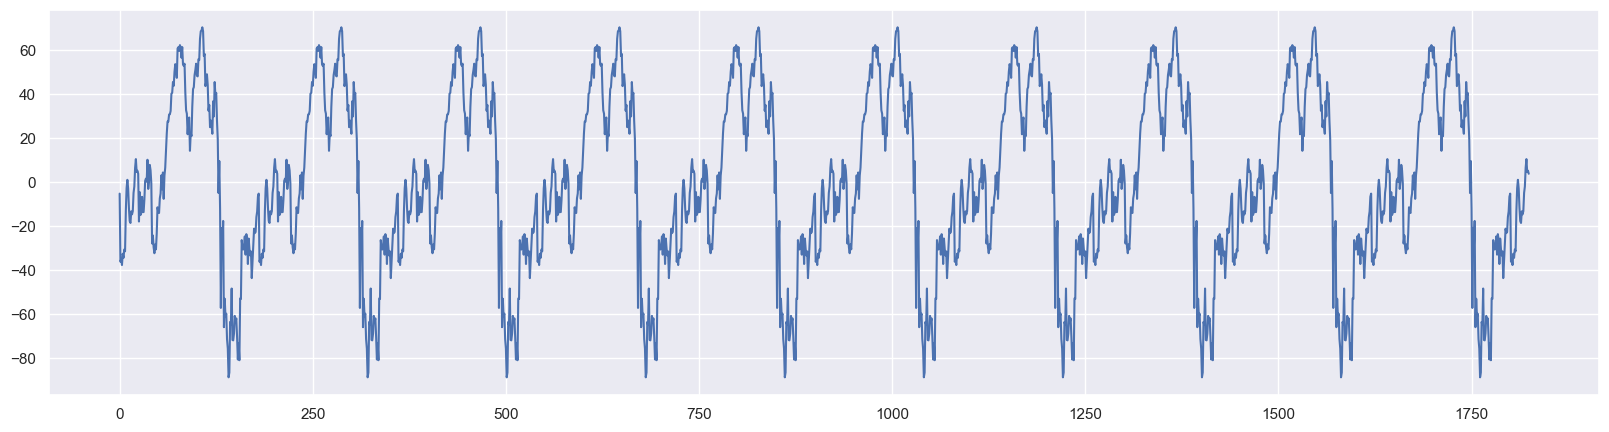

In [71]:
plt.figure(figsize=(20,5))
plt.plot(seasonal)
plt.show()

И рассмотрим остатки.

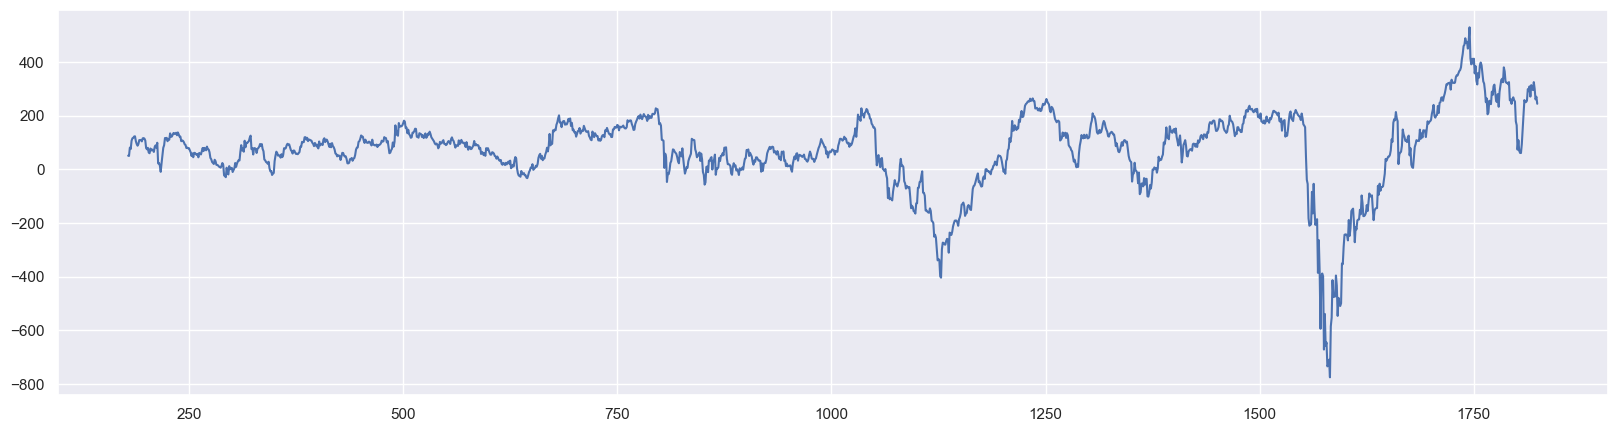

In [72]:
residuals = df.Close - MA - seasonal

plt.figure(figsize=(20,5))

plt.plot(residuals)
plt.show()

Таким образом, мы получили разложение изначального ряда в три компоненты. Можем проверить, что сумма этих компонент действительно даёт нам исходный ряд.

Text(0.5, 1.0, 'Исходный ряд')

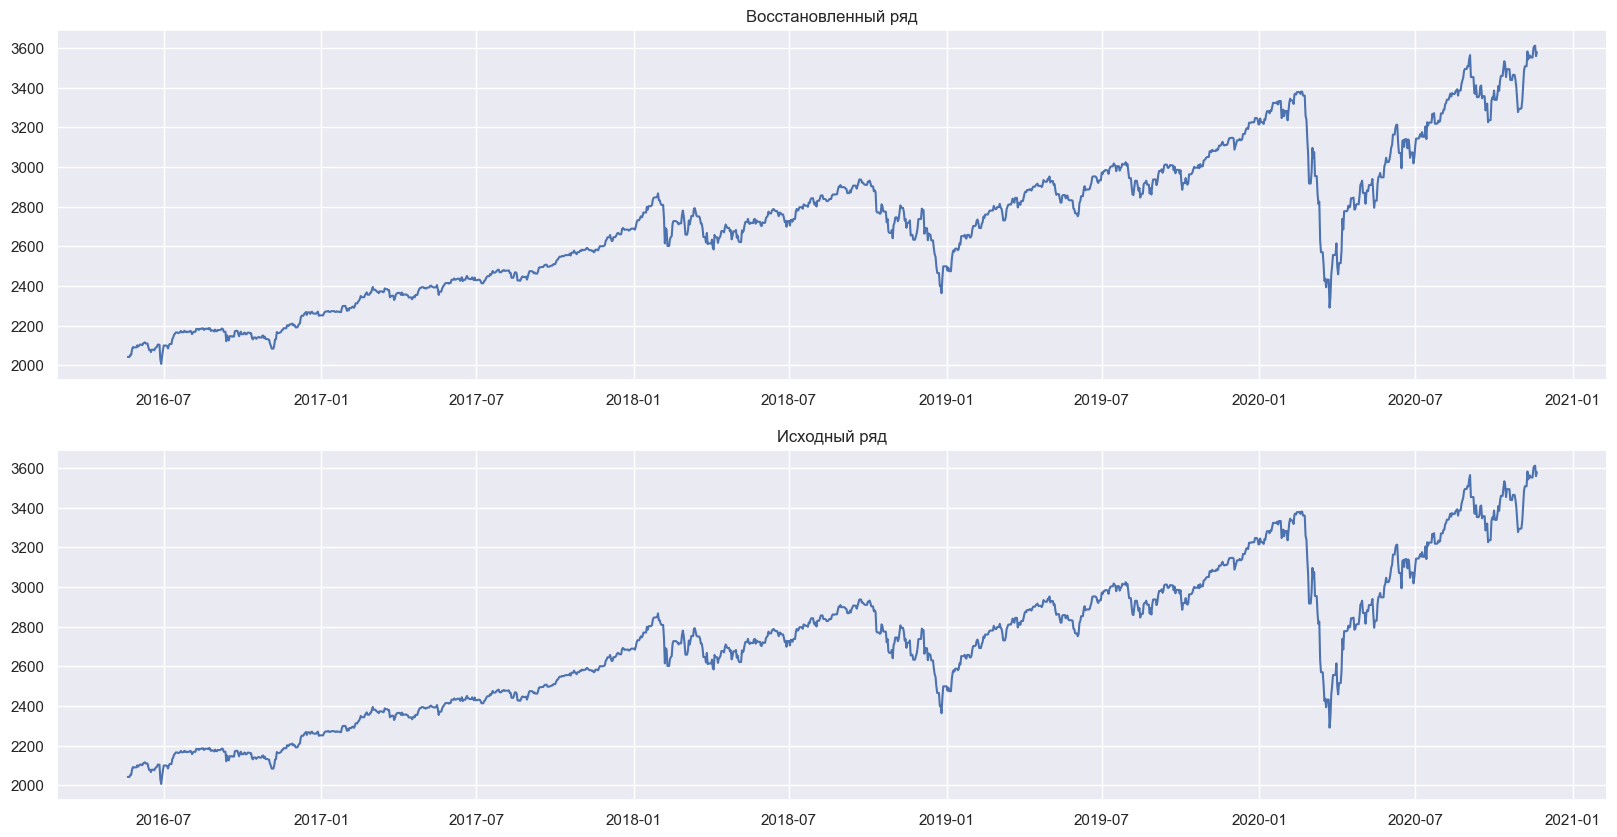

In [139]:
fig, ax = plt.subplots(2, 1, figsize=(20,10))

ax[0].plot(MA + residuals + seasonal)
ax[0].set_title('Восстановленный ряд')
ax[1].plot(df.Open[MA.dropna().index[0]:])
ax[1].set_title('Исходный ряд')


### Автокорреляция

Формула **автокорелляции**, которая определяет характер зависимости значения ряда в момент времени $t$ со значением в момент времени $s$:

$$acf(s, t)=\frac{c(s, t)}{\sqrt{D[x_s]}*\sqrt{D[x_t]}}$$

Анализируя формулу для автокорелляции можно понять, что эта функция возвращает числа в сегменте $[-1; 1]$. При этом, можно утверждать, что чем больше значение модуля $acf(s, t)$, тем сильнее *линейная зависимость* между $x_t$ и $x_s$.

**Определение.** Функция $l_{Δt}(x_t) = x_{t - Δt}$ называется задержкой или **лагом** длины $Δt$. Эта функция возвращает нам $t$-того левого соседа наблюдения $x_t$. Лаги важны не только для описания характеристик временного ряда. Они также служат хорошими дополнительными признаками для моделей машинного обучения, когда мы рассматриваем задачи, ассоциированные с временными рядами.

Загрузим наш датасет еще раз.

In [73]:
df = pd.read_csv('Data/yahoo_stock.csv', sep =',', parse_dates=['Date'], index_col='Date')
df.sort_index(inplace=True)


Вновь обратимся к библиотеке `statsmodels`, но на этот раз воспользуемся функцией `statsmodels.graphics.tsaplots.plot_acf`, чтобы визуализировать корреляции с $j$-м соседом в рамках нашего ряда.

В приведённых ниже графиках по оси абсцисс отложены значения $j$, а по оси ординат - значения соответствующих этим длинам $j$ автокорреляций.

<Figure size 1200x500 with 0 Axes>

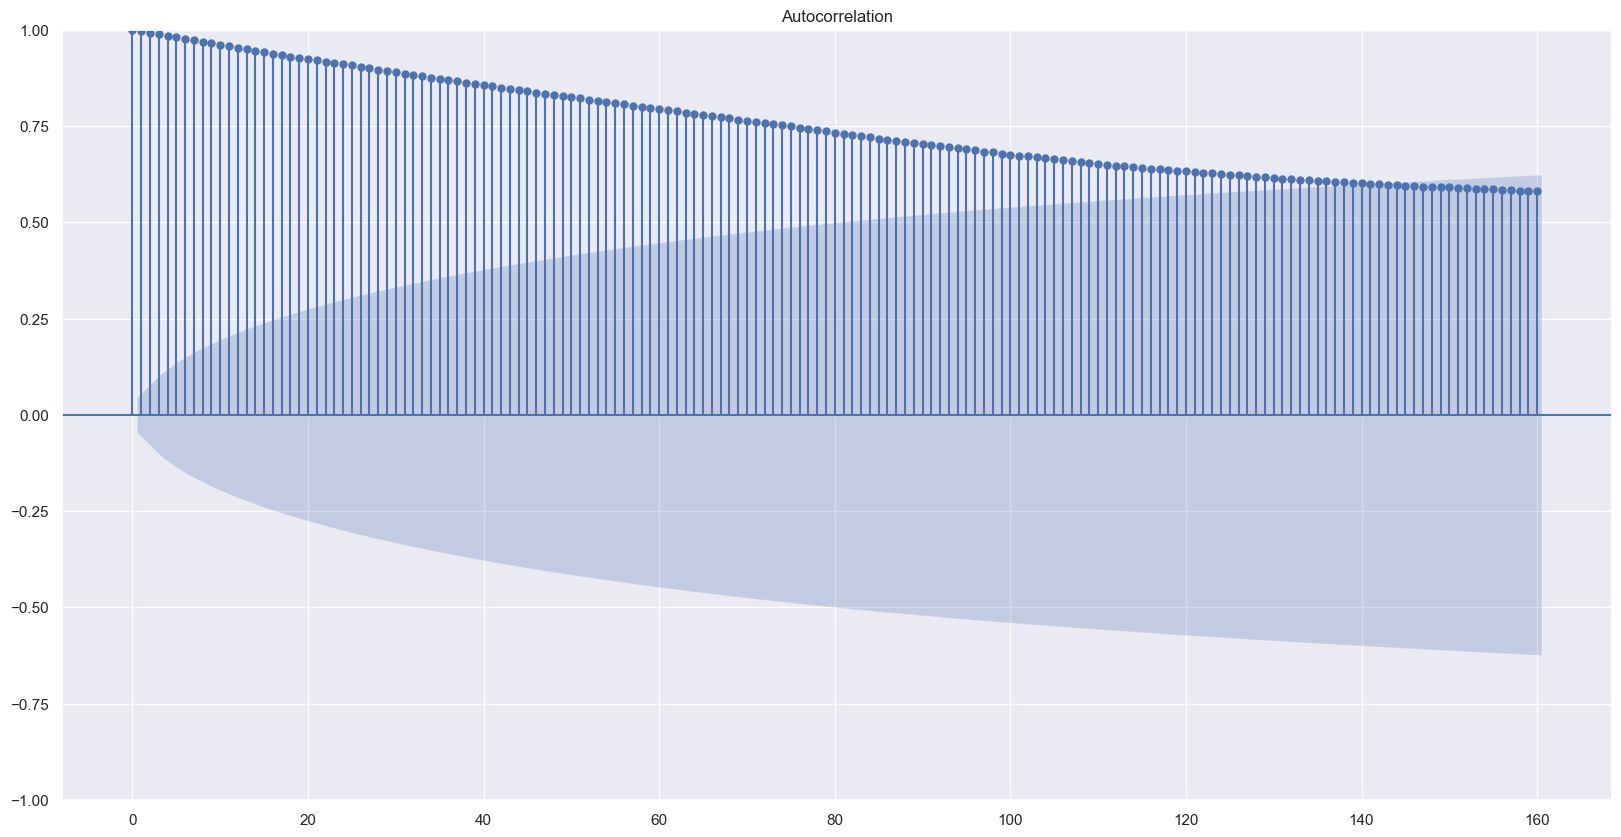

In [82]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12, 5))
plot_acf(df['Close'].values, lags=160)
plt.show()

На графике автокорреляционной функции (ACF) видно, что почти все значения лагов вплоть до ~140 статистически значимы — столбцы выходят за пределы доверительного интервала. Это говорит о сильной зависимости текущих значений временного ряда от прошлых наблюдений.

Такой медленно затухающий автокорреляционный хвост характерен для нестационарных рядов, содержащих тренд или сезонность. В этом случае модель на «сырых» данных может давать искажения, поэтому требуется предварительная обработка.

Второй важной функцией является **частичная автокорелляция** $pacf$. Она похожа на автокорелляцию, только зависимость между $x_t$ и $x_s$ оценивается **по остаткам** (т.е. после удаления влияния всех остальных лагов).

<Figure size 1200x500 with 0 Axes>

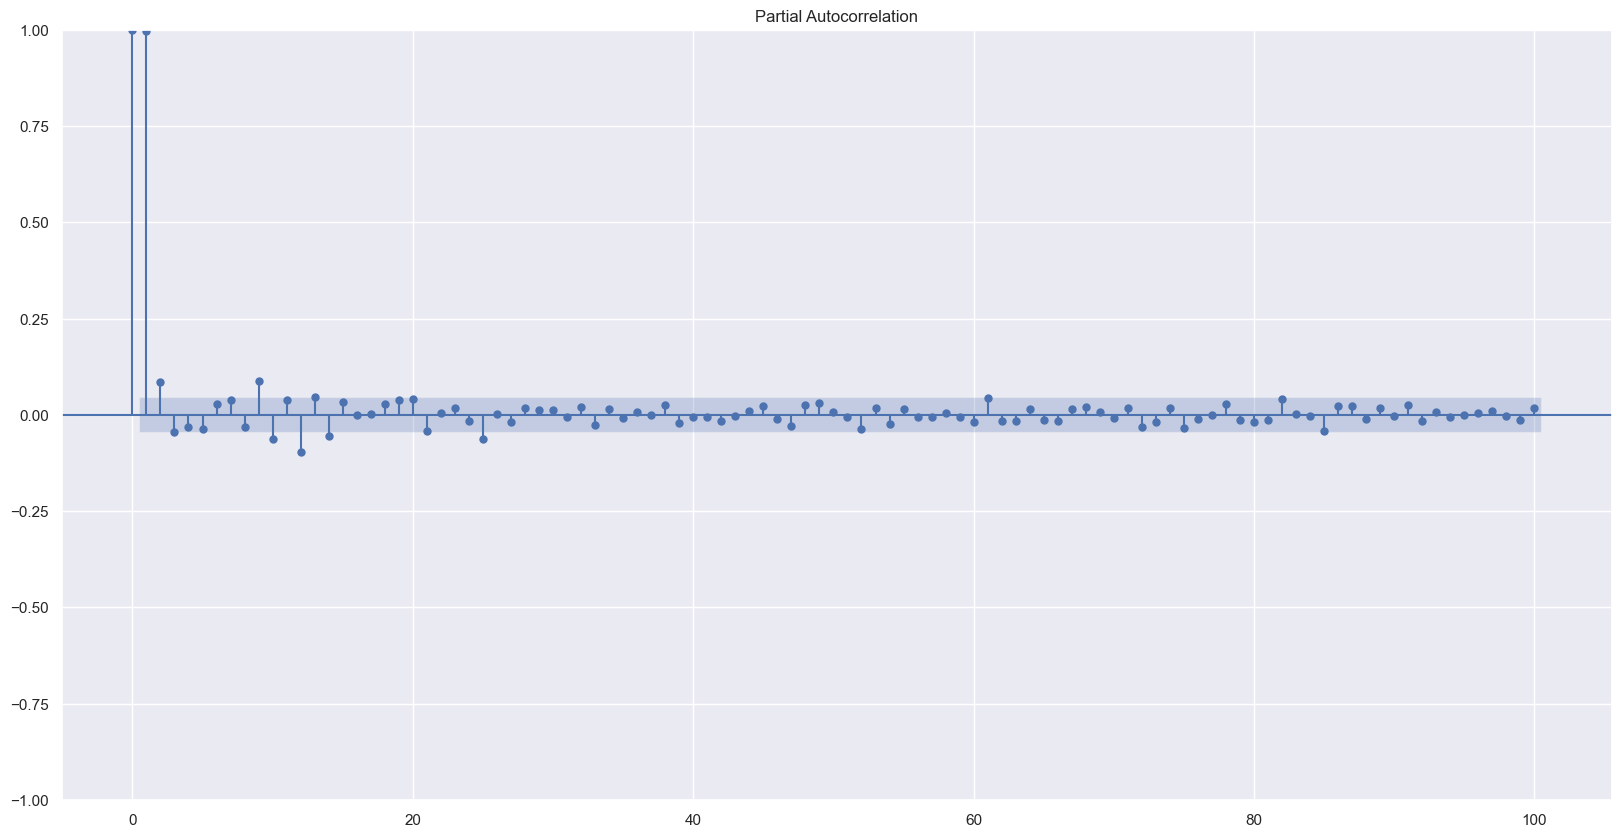

In [87]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(12, 5))
plot_pacf(df["Close"].values, lags=100)
plt.show()

PACF показывает значимые пики только на лагах 1 и 2, что указывает на сильную прямую зависимость текущего значения от двух предыдущих, характерную для AR(2)-процесса. Последующие лаги незначимы, поэтому ряд хорошо описывается моделью AR порядка 2. Для построения ARIMA-модели p=2 — логичный выбор, а параметры d и q можно определить по ACF и стационарности или подобрать автоматически с помощью auto_arima.

### Стационарность

**Стационарный ряд** - ряд, у которого и математическое ожидание, и дисперсия являются *постоянными по времени*:

$$E[x_t]=μ=const, t=0, 1, 2, ...$$
$$D[x_t]=E(x_t-μ_t)^2=σ^2=const, t= 0, 1, 2, ...$$

Проще говоря, стационарный временной ряд **не имеет тренда**. Его характеристики постоянны во времени.

Многие модели ML и DL плохо применимы к нестационарным рядам. По этой причине на практике часто временные ряды искусственно остационаривают. Сделать это можно, например, вычтя из значений наблюдаемых величин тренд (условно - среднее значение).

Проведем **тест Дики-Фуллера (ADH-тест)**, который основан на проверке статистической гипотезы о том, что разница $x_t-x_{t-1}$ представляет собой *стационарный ряд*.

Для выполнения ADH-теста можно использовать функцию addfuller пакета statsmodels.tsa.stattools языка Python:

In [90]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window = 24, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.show()

    #Perform Dickey-Fuller test:
    # p-value
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values,autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

    print(dfoutput)

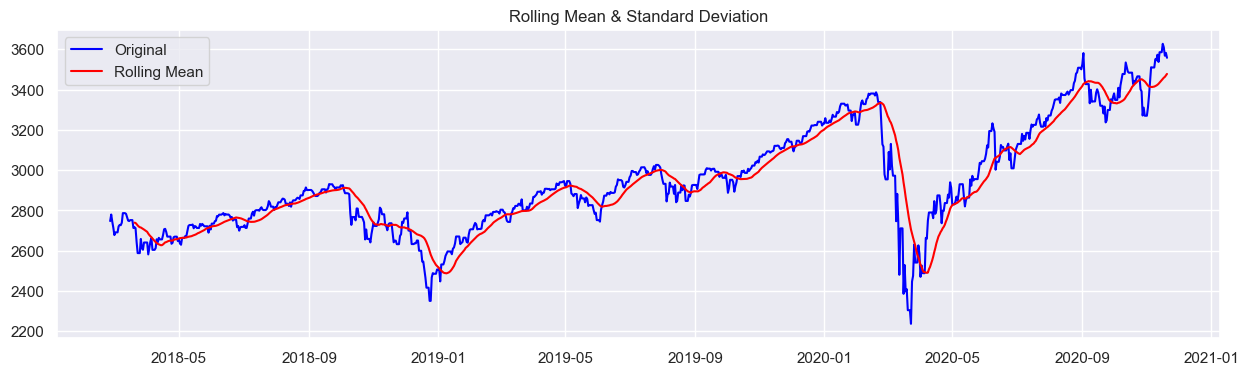

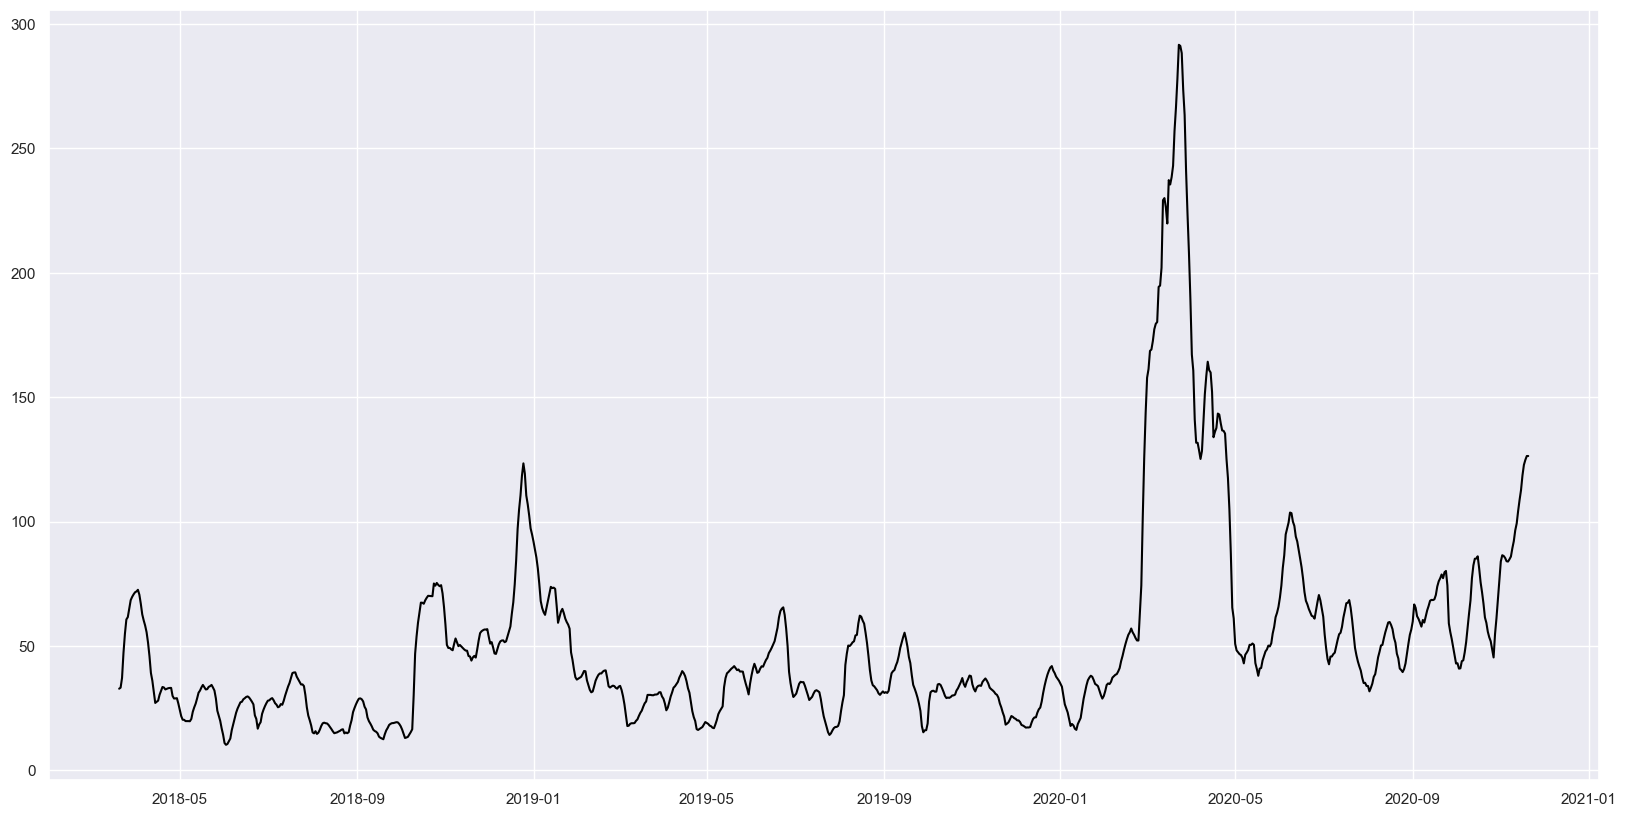

Results of Dickey-Fuller Test:
p-value = 0.5545. The series is likely non-stationary.
Test Statistic                  -1.457280
p-value                          0.554529
#Lags Used                      22.000000
Number of Observations Used    977.000000
Critical Value (1%)             -3.437061
Critical Value (5%)             -2.864503
Critical Value (10%)            -2.568348
dtype: float64


In [91]:
sample_data = df.Close[-1000:]
test_stationarity(sample_data)

Временной ряд нестационарен.

Подходы для того чтобы сделать временной ряд стационарным:
- в случае непостоянства дисперсии - логарифмирование либо преобразование Бокса-Кокса (преобразование временного ряда..., например, логарифмирование вр. ряда);
- почти всегда помогает дифференцирование (переход к попарным разностям ряда): стабилизирует среднее значение ряда, может применяться неоднократно, выделяют также сезонное дифференцирование - попарная разность по сезонам.

### Прогнозирование временных рядов

Задача - предсказать цену закрытия на следующий месяц.

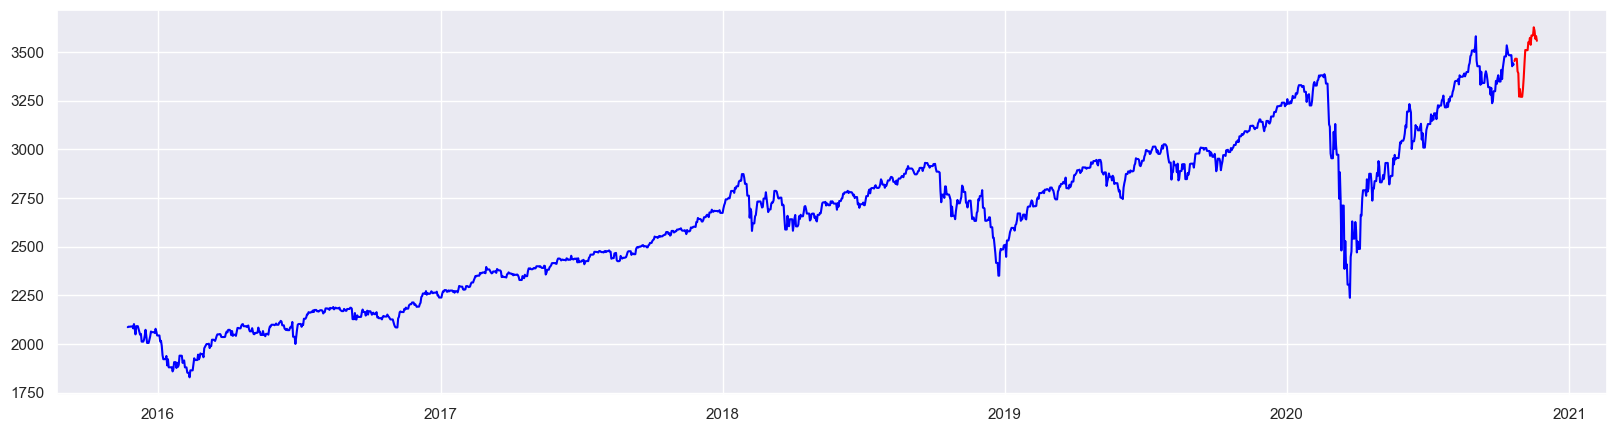

In [92]:
w_days = 30
train = df.iloc[:-w_days] 
val   = df.iloc[-w_days:] 

plt.figure(figsize=(20, 5))

plt.plot(train.Close, color="blue")
plt.plot(val.Close, color="red")

plt.show()

### Baseline

В качестве baseline будем брать среднее значение ряда, умноженное на количество дней.

In [93]:
preds = [train.Close.mean()] * w_days

### Оценка качества прогнозирования

Для оценки качества прогнозирования временных рядов возьмём 2 метрики:

* Известная нам из задач регрессии RMSE:

$$RMSE = \sqrt{\frac{\sum_{i=1}^{N}(Predicted_i - Actual_i) ^ 2}{N}}$$

* Относительная ошибка Mean Absolute Percentage Error:

$$MAPE = 100⋅\frac{1}{N}∑\limits_{i=1}^{N}|\frac{predicted_i - actual_i}{actual_i}|$$

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_actual, y_predicted):
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    return rmse

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('RMSE - ', rmse(val.Close, preds))
print('MAPE - ', mean_absolute_percentage_error(val.Close, preds))

RMSE -  843.3867057634341
MAPE -  24.006351592732734


## Наивный подход

Наивный подход для прогнозирования временных рядов можно выразить при помощи фразы "Завтра = вчера"

${x}_{t} =  x_{t-n}$

Предсказание - завтра будет так же, как и вчера. Нужно всегда использовать в качестве одного из baseline при работе с временными рядами.

In [96]:
preds = train.iloc[-w_days:].Close.values

print('RMSE - ', rmse(val.Close, preds))
print('MAPE - ', mean_absolute_percentage_error(val.Close,  preds))

RMSE -  111.21767327714696
MAPE -  2.8146616814871734


## Предсказание плавающим средним.
Новое значение будет вычисляться на основе среднего за конкретный период, предшествующий прогнозируемому значению.

$${x}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} x_{t-n}$$


In [97]:
n = 10
tr_sample = train.iloc[-n*w_days:]
preds_arr = np.array(tr_sample.Close).reshape(n,-1)

preds = preds_arr.mean(axis = 0)

print('RMSE - ', rmse(val.Close, preds))
print('MAPE - ', mean_absolute_percentage_error(val.Close,  preds))

RMSE -  357.4548770993599
MAPE -  9.696828982564098


## Взвешенное среднее

$${x}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n x_{t-n}$$

Наблюдения за вчера несут больше информации, чем более старые наблюдения. Будем рассматривать линейную комбинацию последних наблюдений. Новые - с большим весом, более старые - с меньшим весом. Пока что выберем эти веса на глаз. Важное условие - веса должны суммироваться к единице.

In [99]:
W = np.array([0.001, 0.004, 0.005, 0.01 , 0.02 , 0.05 , 0.1  , 0.15 , 0.26 , 0.4])
preds_arr_W = np.array([preds_arr[x]*W[x] for x in range(len(W))])
preds = preds_arr_W.sum(axis = 0)

sum(W)

np.float64(1.0)

In [100]:
print('RMSE - ', rmse(val.Close, preds))
print('MAPE - ', mean_absolute_percentage_error(val.Close,  preds))

RMSE -  173.06685750956504
MAPE -  4.455742479503233


## Экспоненциальное сглаживание

Для прогноза будем учитывать все наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные (см. *экспоненциальное взвешенное среднее*).

$${L}_{t} = \alpha \cdot x_t + (1-\alpha) \cdot L_{t-1} $$

In [101]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result[-1]

alpha - на сколько сильно учитываем наблюдения за вчера. Если альфа очень мало, то наблюдение с большим весом за весь интервал будем учитывать. Если альфа большое - то забываем лучше

### Тройное экспоненциальное сглаживание

При помощи экспоненциального сглаживания можно научиться извлекать компоненты временного ряда следующим образом:

- уравнение тренда    
${F}_{tT} = \beta \cdot (L_t - L_{t-1}) + (1-\beta)T_{t-1} $

- уравнение уровня    
${F}_{tL} = \alpha \cdot Y_t/(S_{t-M}) + (1-\alpha) \cdot (L_{t-1} + T_{t-1}) $

- уравнение сезонности    
${F}_{tS} = \gamma \cdot Y_t/(L_t) + (1-\gamma) \cdot (S_{t-M}) $

Попробуем предсказать потребление энергии за последнюю неделю, отделим train и test.

In [183]:
# учитываем уровень, тренд, и сезон
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(np.asarray(train.Close), seasonal_periods=24, trend='add', seasonal='add',).fit()
forecast = pd.Series(fit1.forecast(len(val)))
forecast.index = val.index

print('RMSE - ', rmse(val.Close, forecast))
print('MAPE - ', mean_absolute_percentage_error(val.Close, forecast))

RMSE -  104.56910266776163
MAPE -  2.4914088444613


## Валидация

Для валидации моделей временных рядов хотелось бы применить метод кросс-валидации. Стандартная кросс-валидация, однако, не может быть применена в задачах работы с временными рядами, ведь она никаким образом не учитывает обязательное свойство последовательности объектов. То есть в случае обычной кросс-валидации мы могли позволить себе взять тестовый фолд из начала выборки, а тренировочный - из конца, такой подход был корректным. Здесь же мы хотели бы научиться корректно обрабатывать данные с учётом времени их возникновения.

Вообще таких способов довольно много.
Сравнительно простой способ корректного разбиения временного ряда - использование функции `sklearn.model_selection.TimeSeriesSplit `.

Эта функция работает следующим образом: она разбивает временной ряд $x_t$ на последовательные пары тренировочных и тестовых фолдов. Пара, идущая под $i$-м номером представлена в следующем виде:
$$x_{0:(g⋅i)} → x_{(g⋅i + gap) : (g⋅i + gap + test\_size)}$$

В данном случае под $x_{i:j}$ подразумевается отрезок временного ряда с индексами от $i$ до $j$ $x_i, x_{i+1} ... x_j$, под $g$ имеется в виду инкремент, который вычисляется автоматически исходя из необходимого количества разбиений выборки в кросс-валидации, а $gap$ - это задержка между концом тренировочной и началом тестовой выборки.

In [103]:
from sklearn.model_selection import TimeSeriesSplit
errors = []

tscv = TimeSeriesSplit(n_splits=4)

for train_idx, test_idx in tscv.split(df.Close):
    print('len_train - ', len(train_idx))
    print('len_test - ', len(test_idx))

    # Задаём модель
    model = ExponentialSmoothing(np.asarray(df.Close.iloc[train_idx]) ,seasonal_periods=24 , seasonal='add').fit()

    # Делаем предсказание
    forecast = pd.Series(model.forecast(len(test_idx)))

    # Считаем ошибку
    actual = df.Close.iloc[test_idx]
    error = rmse(actual.values, forecast.values)
    errors.append(error)

len_train -  365
len_test -  365
len_train -  730
len_test -  365
len_train -  1095
len_test -  365
len_train -  1460
len_test -  365


In [104]:
errors

[229.95988552859953, 173.51573021931546, 251.6789953912051, 281.8031007842136]

In [105]:
np.mean(errors)

np.float64(234.23942798083343)

### ARIMA

Одной из самых популярных моделей прогнозирования временных рядов, безусловно, является **ARIMA**.

**ARIMA** - AR (Авторегрессия) + I(Интегрирование) + MA(Скользящее среднее).

ARIMA - это применение модели ARMA, которую мы рассмотрели ранее, к **приращениям** исходного временного ряда. То есть вместо исходного временного ряда $x_1, x_2 ... x_T$ рассматривается ряд $d_1 = x_2 - x_1, d_2 = x_3 - x_2 ...$

Формирование прогноза для ряда $d_1, d_2 ...$ приводит нас к прогнозу для ряда $x_1, x_2 ...$, ведь $\hat{x}_i = d_1 + d_2 + ... + d_{i-1} =\hat{x}_{i-1} + d_{i-1}$.

Именно отсюда берется символ $I$ в названии модели: для получения прогноза по исходному ряду мы интегрируем прогнозируемые приращения.

Модель ARIMA реализована в модуле `statsmodels.tsa.arima.model.ARIMA`.

Для её использования необходимо задать 2 параметра:

* `endog` - непосредственно временной ряд
* `order: (p, d, q)` - набор констант, характеризующих поведение модели. Здесь p - порядок модели авторегрессии (то есть максимальный лаг), d - параметр дифференцирования временного ряда (то есть максимальный порядок разности при формировании ряда $d_1 ... $, ведь мы также можем рассмотреть ряд $d_2 - d_1, d_3 - d_2$ и т.д.), а параметр q - длина окна сглаживания.

In [106]:
mod = sm.tsa.arima.ARIMA(val.Close, order=(1, 0, 0))
res = mod.fit()
res.summary()

C:\Users\masha\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\masha\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\masha\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                   30
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -153.759
Date:                Mon, 07 Jul 2025   AIC                            313.519
Time:                        00:07:30   BIC                            317.722
Sample:                    10-22-2020   HQIC                           314.863
                         - 11-20-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3485.5242    100.481     34.688      0.000    3288.586    3682.463
ar.L1          0.9210      0.076     12.162      0.000       0.773       1.069
sigma2      1555.9673    342.005      4.550      0.000     885.650    2226.284
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                 9.44
Prob(Q):                              0.49   Prob(JB):                         0.01
Heteroskedasticity (H):               0.36   Skew:                            -0.96
Prob(H) (two-sided):                  0.12   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

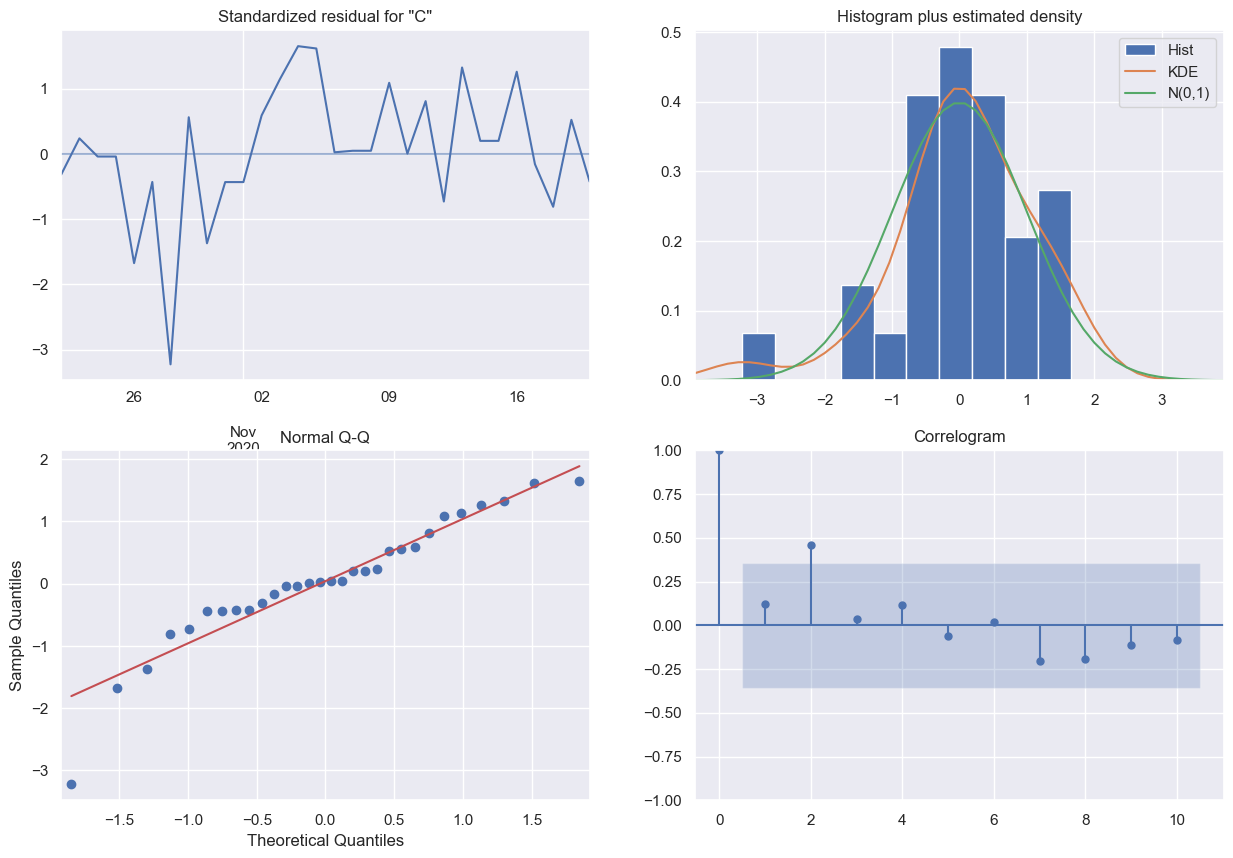

In [107]:
res.plot_diagnostics(figsize=(15, 10))
plt.show()

1. Standardized Residuals:
Остатки колеблются около нуля без выраженной структуры, что говорит о том, что модель хорошо описывает временной ряд. Наблюдается один выброс, но в целом поведение остатков допустимо и указывает на адекватность модели.

2. Histogram + KDE:
Распределение остатков близко к нормальному — гистограмма симметрична, а оценка плотности (KDE) хорошо совпадает с теоретическим нормальным распределением. Это подтверждает, что ошибки модели имеют примерно нормальное распределение.

3. Normal Q-Q Plot:
Точки в основном лежат вдоль прямой, что также указывает на нормальность остатков. Незначительные отклонения в хвостах допустимы и не влияют существенно на выводы о качестве модели.

4. Correlogram (ACF остатков):
Почти все автокорреляции остатков находятся в пределах доверительного интервала, за исключением небольшого превышения на лаге 1. Это свидетельствует об отсутствии существенной автокорреляции и подтверждает, что модель хорошо устраняет зависимость во временном ряде.


### Выводы:
- Остатки примерно нормальны, неавтокоррелированы, стационарны.

- Модель ARIMA подобрана хорошо, диагностические признаки говорят о её адекватности.

- Можно использовать эту модель для прогнозирования.

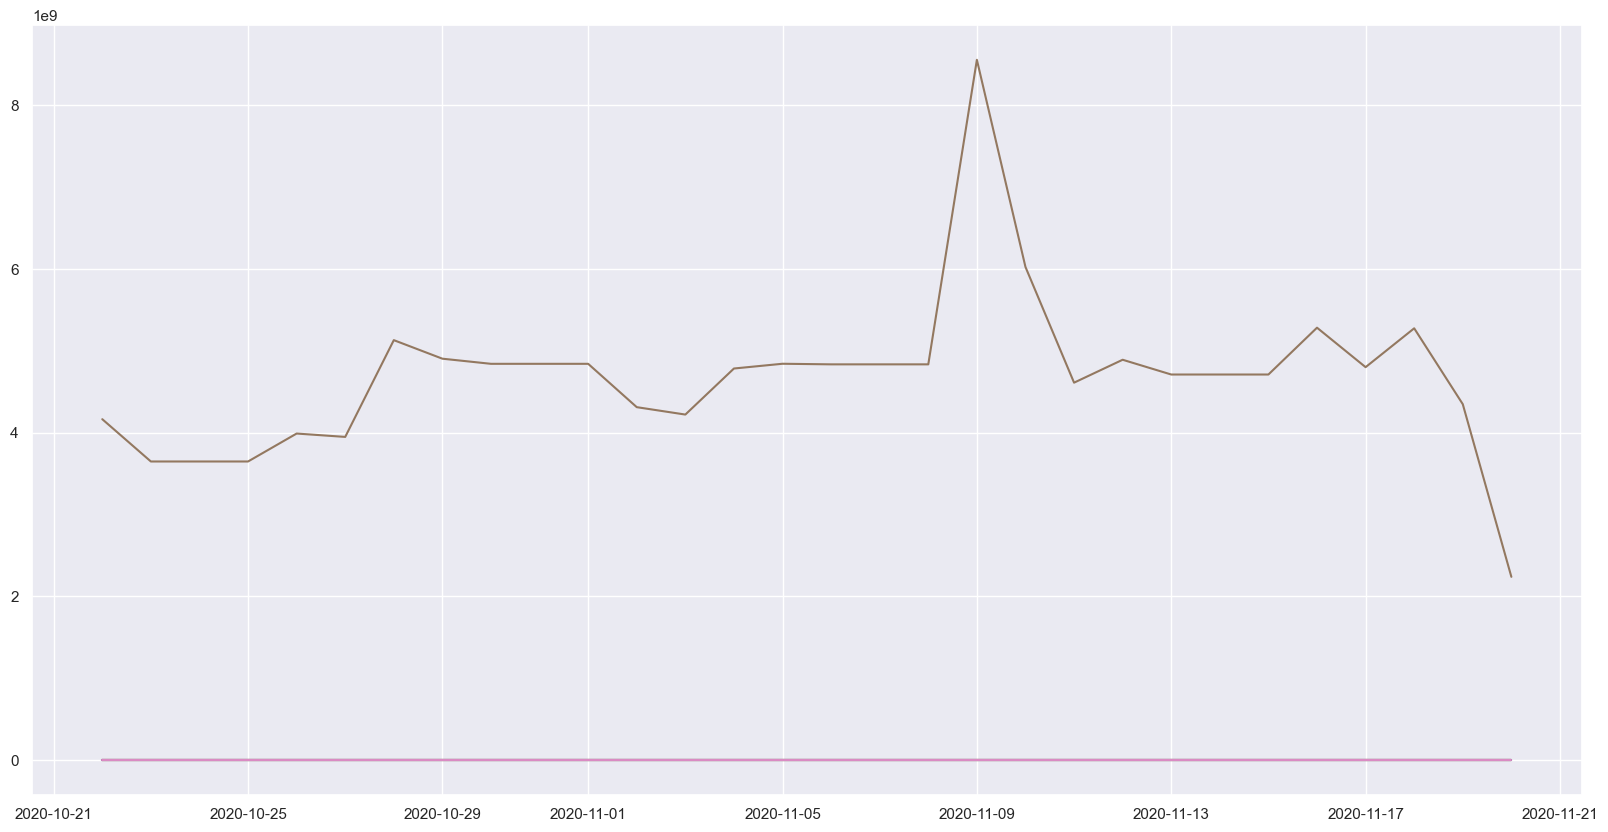

In [108]:
preds = res.predict(dynamic=False)
plt.plot(val.Close)
plt.plot(val)

In [109]:
print('RMSE - ', rmse(val.Close, preds))

RMSE -  39.81266758302347


Результат неплохой. Но, вообще говоря, мы можем перебрать много различных параметров ARIMA и улучшить его.

In [110]:
import itertools
import warnings
import tqdm
from tqdm.auto import tqdm
warnings.filterwarnings("ignore")

p = range(0,10)
d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
best_params = (0,0,0)
best_rmse = np.inf

for params in tqdm(pdq):
  model_test = sm.tsa.arima.ARIMA(val.Close, order = params)
  result_test = model_test.fit()
  preds = result_test.predict(dynamic=False)

  rmse_ = rmse(val.Close, preds)
  if rmse_ < best_rmse:
    best_params = params
    best_rmse = rmse_
print(best_params, best_rmse)

100%|██████████| 90/90 [00:48<00:00,  1.86it/s]

(8, 0, 2) 31.59859180937717


ARIMA дает хороший результат, если есть много времени для анализа: можно все настроить на валидации и получить хорошую точность.

Но на практике ARIMA долго работает как раз из-за перебора параметров.

ARIMA дает возможность сгенерировать новые фичи.

### Кластеризация

Разобьем ряд на окна, для каждого окна вычислим признаки:

In [135]:
window_size = 30
segments = []

for start in range(0, len(df) - window_size, window_size):
    segment = df['Close'].iloc[start:start + window_size]
    if len(segment) == window_size:
        segments.append(segment.values)

features = []

for seg in segments:
    stats = {
        'mean': np.mean(seg),
        'std': np.std(seg),
        'min': np.min(seg),
        'max': np.max(seg),
        'autocorr_1': pd.Series(seg).autocorr(lag=1),
        'autocorr_5': pd.Series(seg).autocorr(lag=5)
    }
    features.append(stats)

features_df = pd.DataFrame(features)



Кластеризация методом k-means. Побдерем оптимальное к-значение

k=2 | silhouette_score=0.5247
k=3 | silhouette_score=0.5438
k=4 | silhouette_score=0.4738
k=5 | silhouette_score=0.4869
k=6 | silhouette_score=0.4496
k=7 | silhouette_score=0.4464
k=8 | silhouette_score=0.4692
k=9 | silhouette_score=0.3976


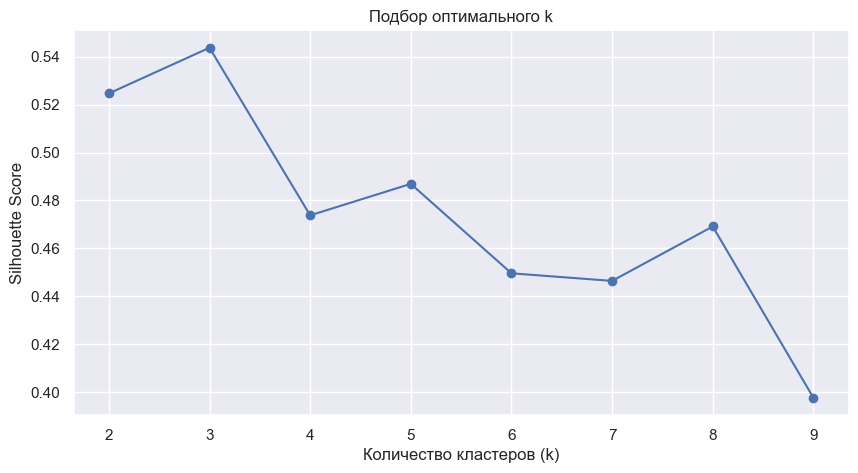

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = features_df.drop(columns='cluster', errors='ignore') 

sil_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    sil_scores.append(score)
    print(f"k={k} | silhouette_score={score:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(k_range, sil_scores, marker='o')
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Silhouette Score")
plt.title("Подбор оптимального k")
plt.grid(True)
plt.show()

optimal_k = k_range[np.argmax(sil_scores)]

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
features_df['cluster'] = kmeans.fit_predict(X)

Визуализация кластеров

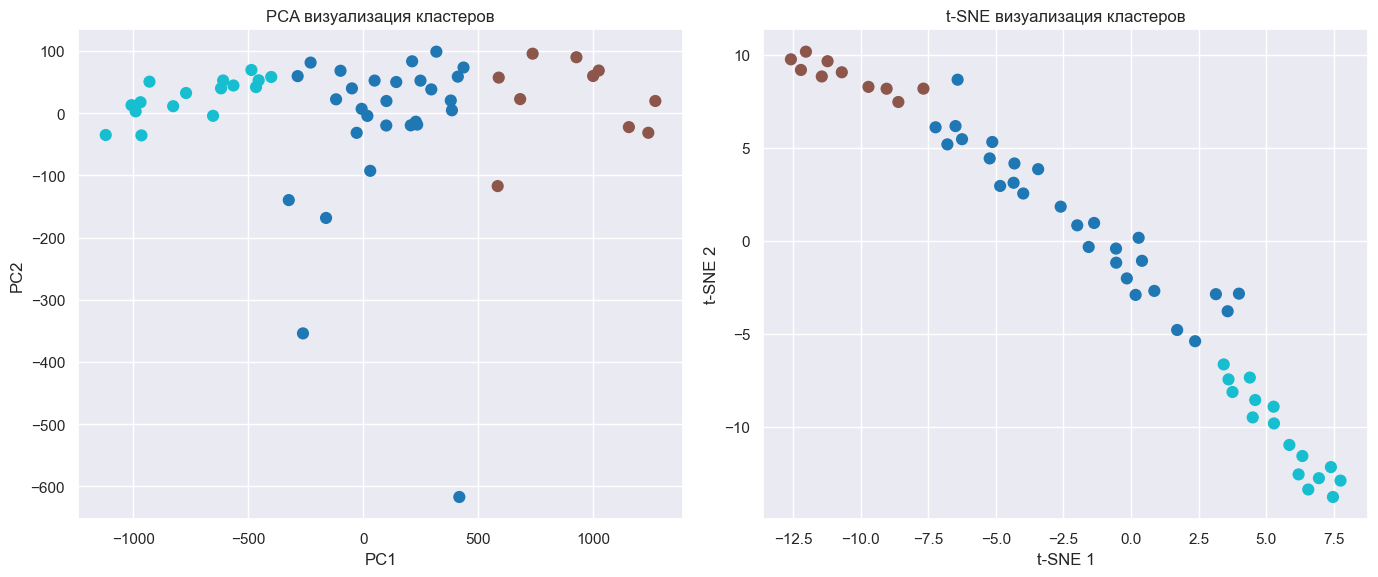

In [182]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = features_df.drop(columns='cluster', errors='ignore')
labels = features_df['cluster']

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# t-SNE
tsne = TSNE(n_components=2, perplexity=10, random_state=42, n_iter=1000)
tsne_result = tsne.fit_transform(X)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PCA-график
axes[0].scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='tab10', s=60)
axes[0].set_title('PCA визуализация кластеров')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].grid(True)

# t-SNE-график
axes[1].scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab10', s=60)
axes[1].set_title('t-SNE визуализация кластеров')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].grid(True)

plt.tight_layout()
plt.show()


PCA — линейный метод, который сохраняет глобальную структуру данных и отражает основные направления вариации, поэтому кластеры на PCA выглядят более растянутыми и упорядоченными. t-SNE — нелинейный метод, который фокусируется на сохранении локальных соседств и плотности, из-за чего кластеры на t-SNE часто выглядят более компактными и искажёнными, лучше выявляя мелкие подгруппы внутри данных.

### ML-модель: линейная регрессия

Загрузим данные еще раз:

In [153]:
df = pd.read_csv('Data/yahoo_stock.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()

Подготовка данных для моделей

In [171]:
from sklearn.preprocessing import StandardScaler

df = df.sort_index()

X = df[['High', 'Low', 'Open', 'Adj Close']]
y = df['Close']

n = len(df)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Еще раз посмотрим на корреляционную матрицу

<Axes: >

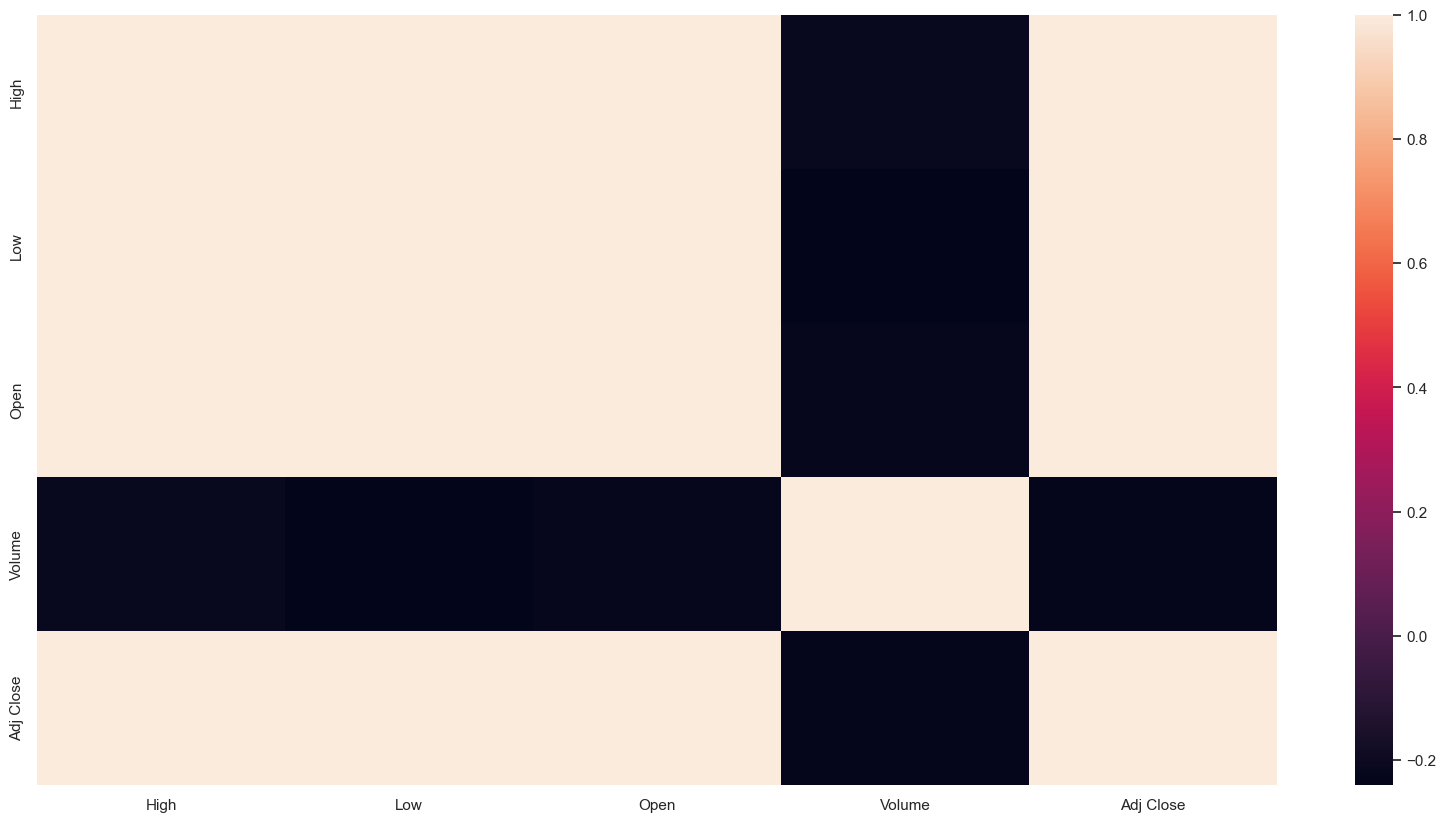

In [ ]:
from seaborn import heatmap
heatmap(X_train.corr())

В моделях не будет учитывать признак "Volume" из-за его отрицательной, нестандартной для временного ряда корреляции с остальными признаками

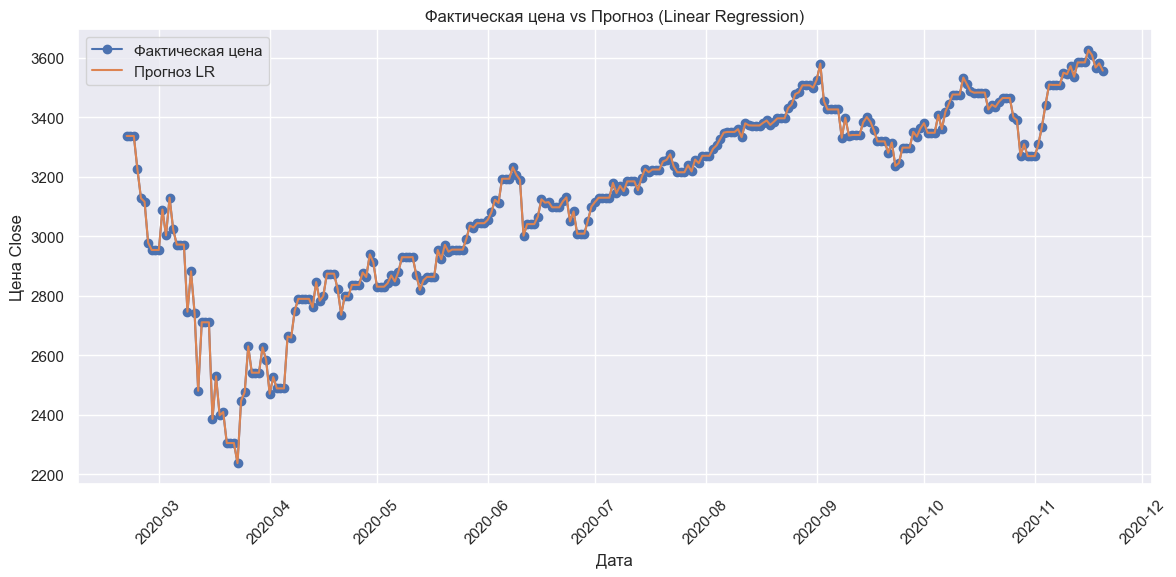

In [168]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

plt.figure(figsize=(12,6))
plt.plot(df.index[val_end:], y_test.values, label='Фактическая цена', marker='o')
plt.plot(df.index[val_end:], y_pred_lr, label='Прогноз LR')
plt.xlabel('Дата')
plt.ylabel('Цена Close')
plt.title('Фактическая цена vs Прогноз (Linear Regression)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



Линейная регрессия хорошо прогнозирует временной ряд, когда зависимость между признаками (например, лагами и трендами) и целевой переменной близка к линейной и стабильной во времени. Она эффективно улавливает простые тренды и сезонные паттерны без переобучения, особенно на небольших и умеренно сложных данных, где сложные модели могут излишне усложнять прогноз или не находить значимых нелинейных зависимостей.